In [1]:
import torch
from pythae.models import AutoModel

device = "cuda" if torch.cuda.is_available() else "cpu"

%load_ext autoreload
%autoreload 2

In [43]:
model = AutoModel.load_from_folder('/home/clement/Documents/rvae/benchmark_VAE/examples/notebooks/models_training/from_jz/LVAE_IAF_training_2022-11-17_17-09-41/final_model').eval().to(device)
model.model_config

LVAE_IAF_Config(name='LVAE_IAF_Config', input_dim=(3, 28, 28), latent_dim=16, uses_default_encoder=False, uses_default_decoder=False, reconstruction_loss='mse', n_obs_per_ind=12, n_made_blocks=2, n_hidden_in_made=3, hidden_size=128, warmup=10, beta=1.0, context_dim=None, prior='standard', vamp_number_components=500, linear_scheduling_steps=0, posterior='gaussian')

In [46]:
if model.prior == "standard":
    print("standard")
    z = torch.randn(50, model.latent_dim).to(device)

elif model.prior == "vamp":
    print("vamp prior")
    if model.vamp_number_components < 10:
        means = []
        for i in range(int(10 / model.vamp_number_components)+1):
            means.append(
                model.pseudo_inputs(
                    model.idle_input.to(device)
                ).reshape((model.vamp_number_components,) + model.model_config.input_dim))

        means = torch.cat(means)[:10].reshape((10,) + model.model_config.input_dim)

    else:
        means = model.pseudo_inputs(model.idle_input.to(device))[
                    :10
                ].reshape((10,) + model.model_config.input_dim)

    encoder_output = model.encoder(means)
    mu, log_var = (
        encoder_output.embedding,
        encoder_output.log_covariance,
    )
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    z = mu + eps * std

generation = torch.clamp(model.generate(z).detach(), 0, 1)

standard


In [34]:
#import os
#train_data = torch.load(os.path.join('/gpfswork/rech/wlr/uhw48em/rvae/data/starmen/starmen_1000.pt'), map_location="cpu")[:700].to(device)
#train_data = torch.load(os.path.join('/gpfswork/rech/wlr/uhw48em/rvae/data/sprites/Sprites_train.pt'), map_location="cpu")['data'][:-1000].to(device)
#train_data = torch.load(os.path.join('/gpfswork/rech/wlr/uhw48em/rvae/data/3d_chairs/3D_chairs_color.pt'), map_location="cpu")[:1000].to(device)
#train_data = torch.load(os.path.join('/gpfswork/rech/wlr/uhw48em/rvae/data/zzzcolormnist/train_12_long_color_mnist.pt'), map_location="cpu").to(device)#[:10000].to(device)
#generation[0].shape
#(generation[0].unsqueeze(0).cuda() - train_data).shape
#idx = 3
#lim = generation.shape[1]

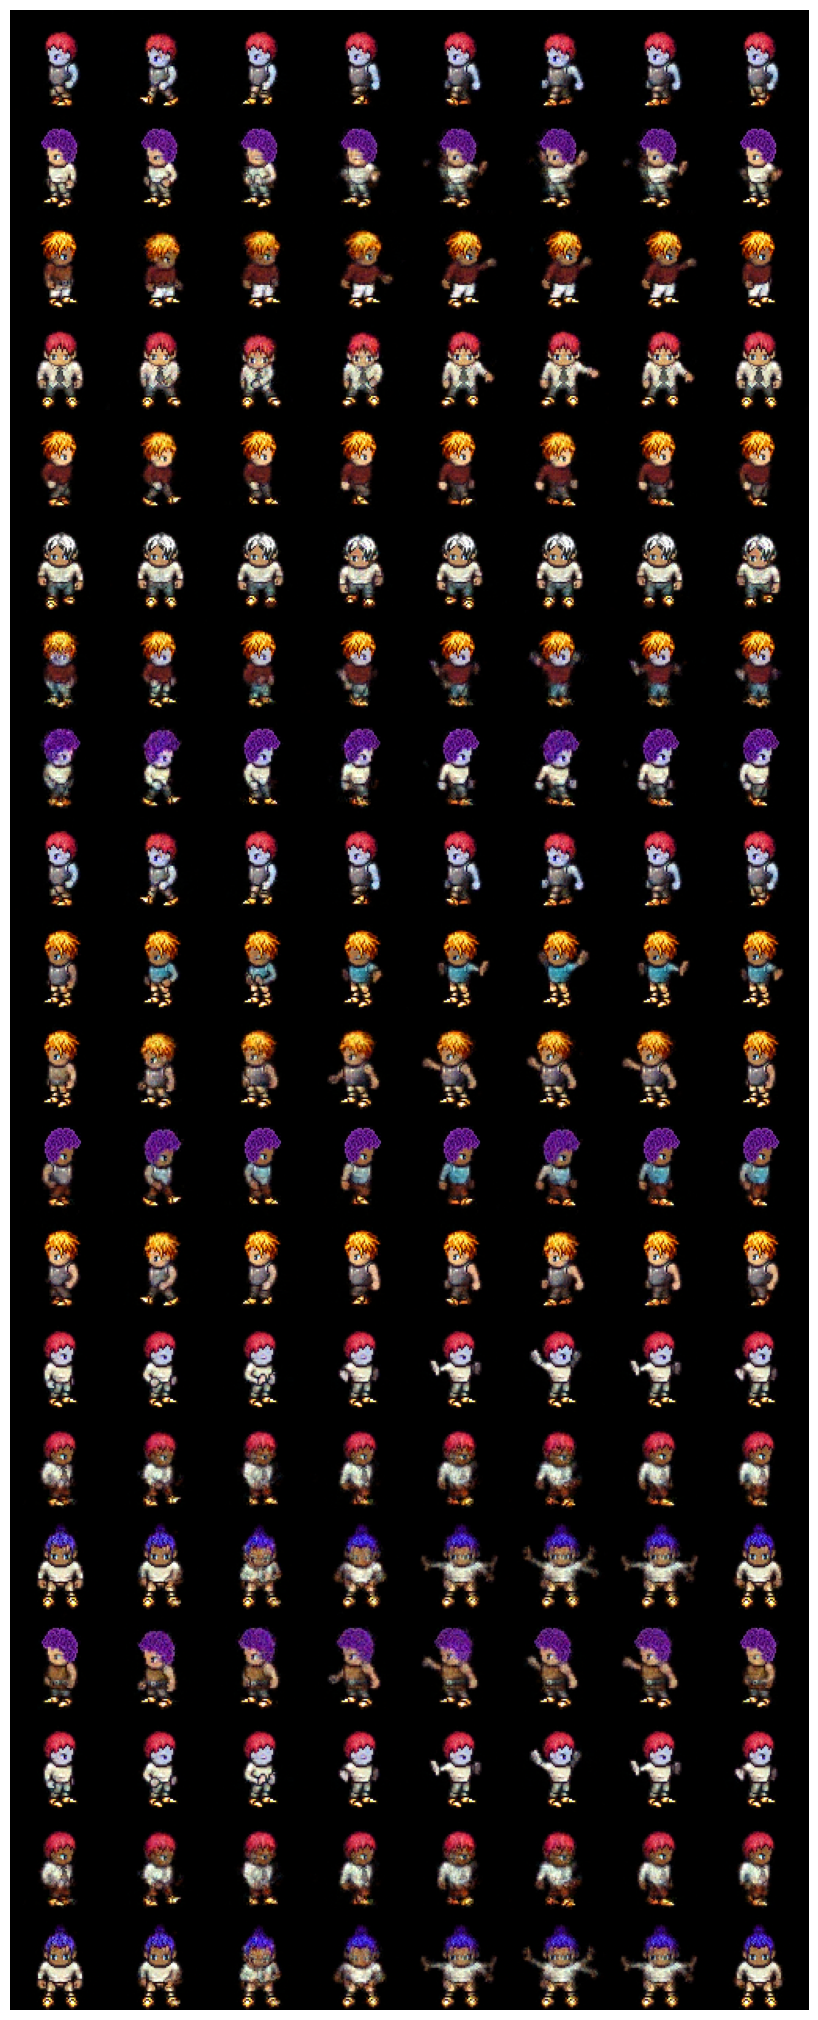

In [35]:
import matplotlib.pyplot as plt
import numpy as np

idx = [
    47, 8, 31, 11, 30, 14, 16, 5, 47, 33, 1, 2, 9, 40, 41, 42, 37, 40, 41, 42
]

lim = generation.shape[1]

fig, axes = plt.subplots(20, lim, figsize=(lim, 20))
for i in range(20):
    for k in range(lim):
        axes[i][k].imshow(np.moveaxis(generation[idx[i], k].cpu().numpy(), 0, 2), cmap='gray')
        axes[i][k].axis('off')
plt.tight_layout(pad=0)
#plt.savefig(f"plots/{model.model_name}_{model.prior}_colormnist.pdf", bbox_inches="tight")

In [96]:
from collections import Counter
Counter(idx)

Counter({3: 1,
         6: 1,
         38: 1,
         4: 1,
         8: 1,
         31: 1,
         11: 1,
         30: 1,
         14: 1,
         16: 1,
         5: 1,
         47: 1,
         33: 1,
         1: 1,
         2: 1,
         9: 1,
         40: 1,
         41: 1,
         42: 1,
         37: 1})

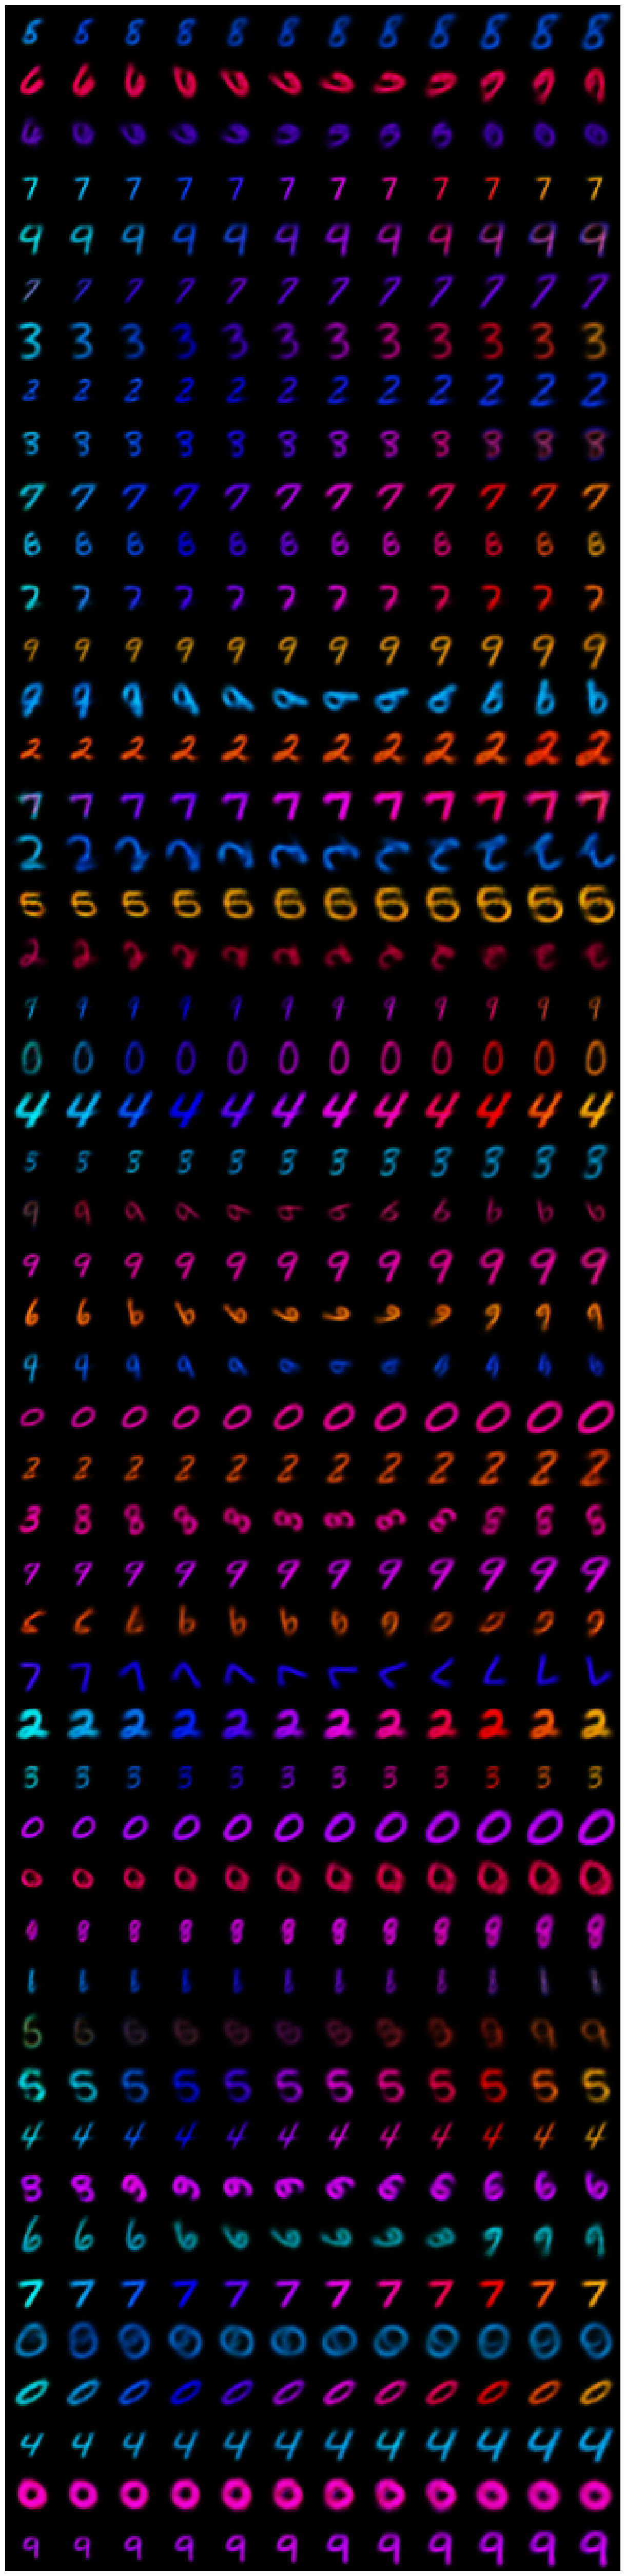

In [47]:
import matplotlib.pyplot as plt
import numpy as np

idx = [20, 49, 5, 3, 6, 48, 13, 23, 35, 24]

lim = generation.shape[1]

fig, axes = plt.subplots(50, lim, figsize=(lim, 50))
for i in range(50):
    for k in range(lim):
        axes[i][k].imshow(np.moveaxis(generation[i, k].cpu().numpy(), 0, 2), cmap='gray')
        axes[i][k].axis('off')
plt.tight_layout(pad=0)

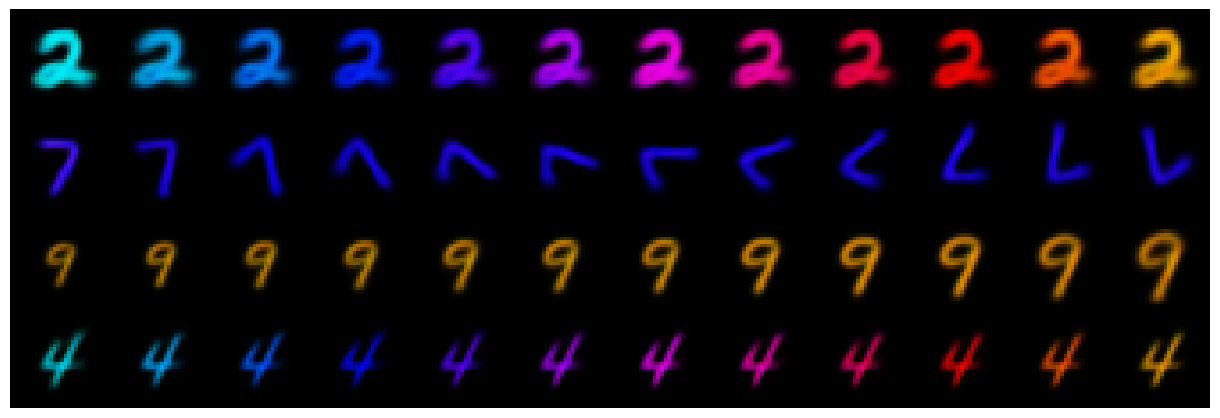

In [53]:
import matplotlib.pyplot as plt
import numpy as np

idx = [
    33, 32, 12, 41
]

lim = generation.shape[1]

fig, axes = plt.subplots(4, lim, figsize=(lim, 4))
for i in range(4):
    for k in range(lim):
        axes[i][k].imshow(np.moveaxis(generation[idx[i], k].cpu().numpy(), 0, 2), cmap='gray')
        axes[i][k].axis('off')
plt.tight_layout(pad=0)
#plt.savefig(f"plots/{model.model_name}_{model.prior}_colormnist_short.png", bbox_inches="tight")

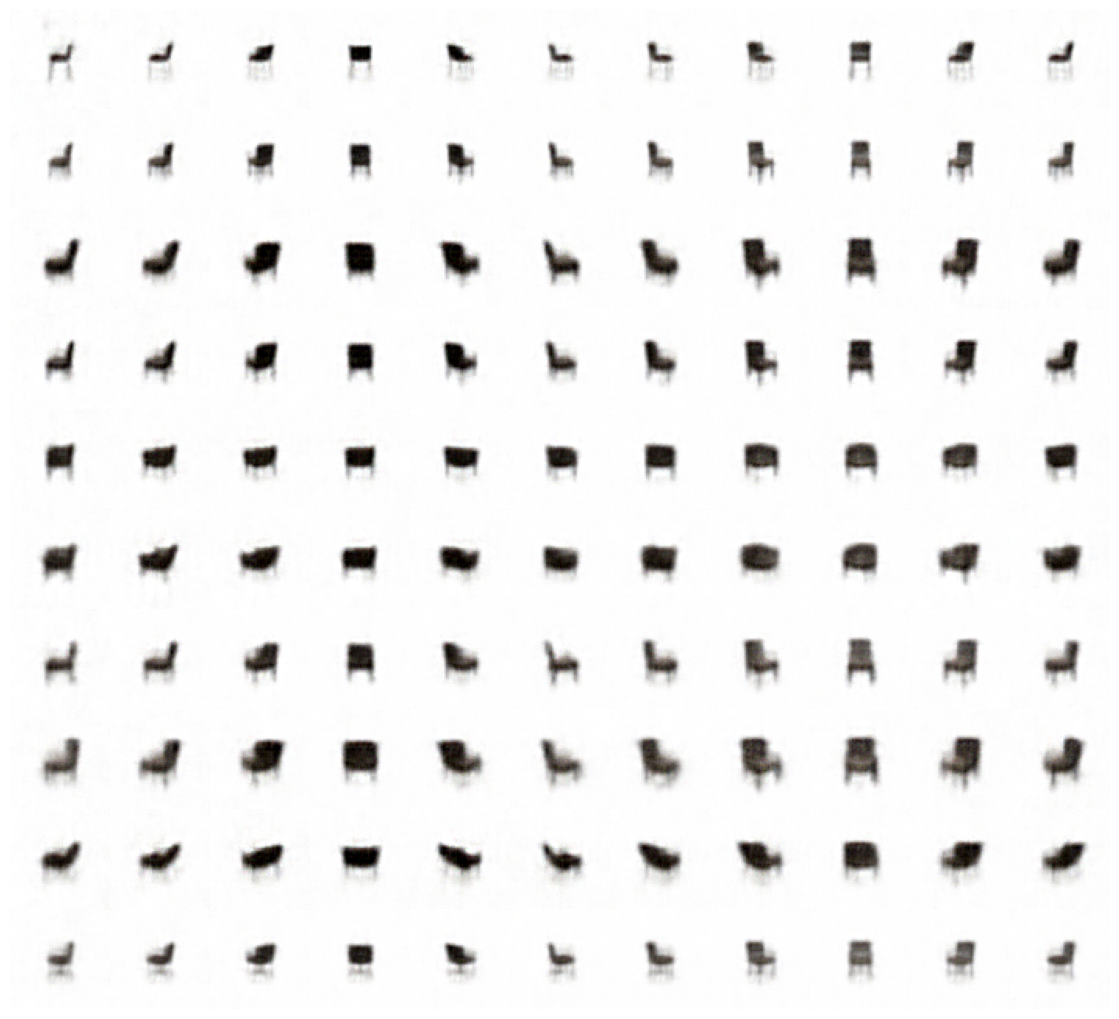

In [350]:
lim = generation.shape[1]

fig, axes = plt.subplots(10, lim, figsize=(lim, 10))
for i in range(10):
    for k in range(lim):
        axes[i][k].imshow(np.moveaxis(generation[0+i, k].cpu().numpy(), 0, 2), cmap='gray')
        axes[i][k].axis('off')
plt.tight_layout(pad=0)

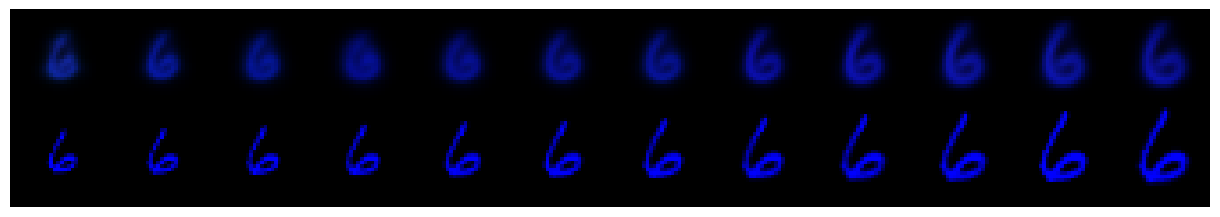

In [ ]:
closest = torch.argmin(torch.norm(generation[idx].unsqueeze(0).cuda().reshape(1, -1) - train_data.reshape(-1, lim*np.prod(model.input_dim)), dim=-1))
# Train recon
fig, axes = plt.subplots(2, lim, figsize=(lim, 2))

for k in range(lim):
    axes[0][k].imshow(np.moveaxis(generation[idx, k].cpu().numpy(), 0, 2), cmap='gray')
    axes[0][k].axis('off')
    axes[1][k].imshow(np.moveaxis(train_data[closest, k].cpu().numpy(), 0, 2), cmap='gray')
    axes[1][k].axis('off')
plt.tight_layout(pad=0)
#plt.savefig(f"plots/closest_{model.model_name}_{model.prior}_colormnist_1.pdf", bbox_inches="tight")

In [8]:
import os
import matplotlib.pyplot as plt
import numpy as np
test_data = torch.load(os.path.join('/gpfswork/rech/wlr/uhw48em/rvae/data/colormnist/test_12_long_color_mnist.pt'), map_location="cpu").to(device)

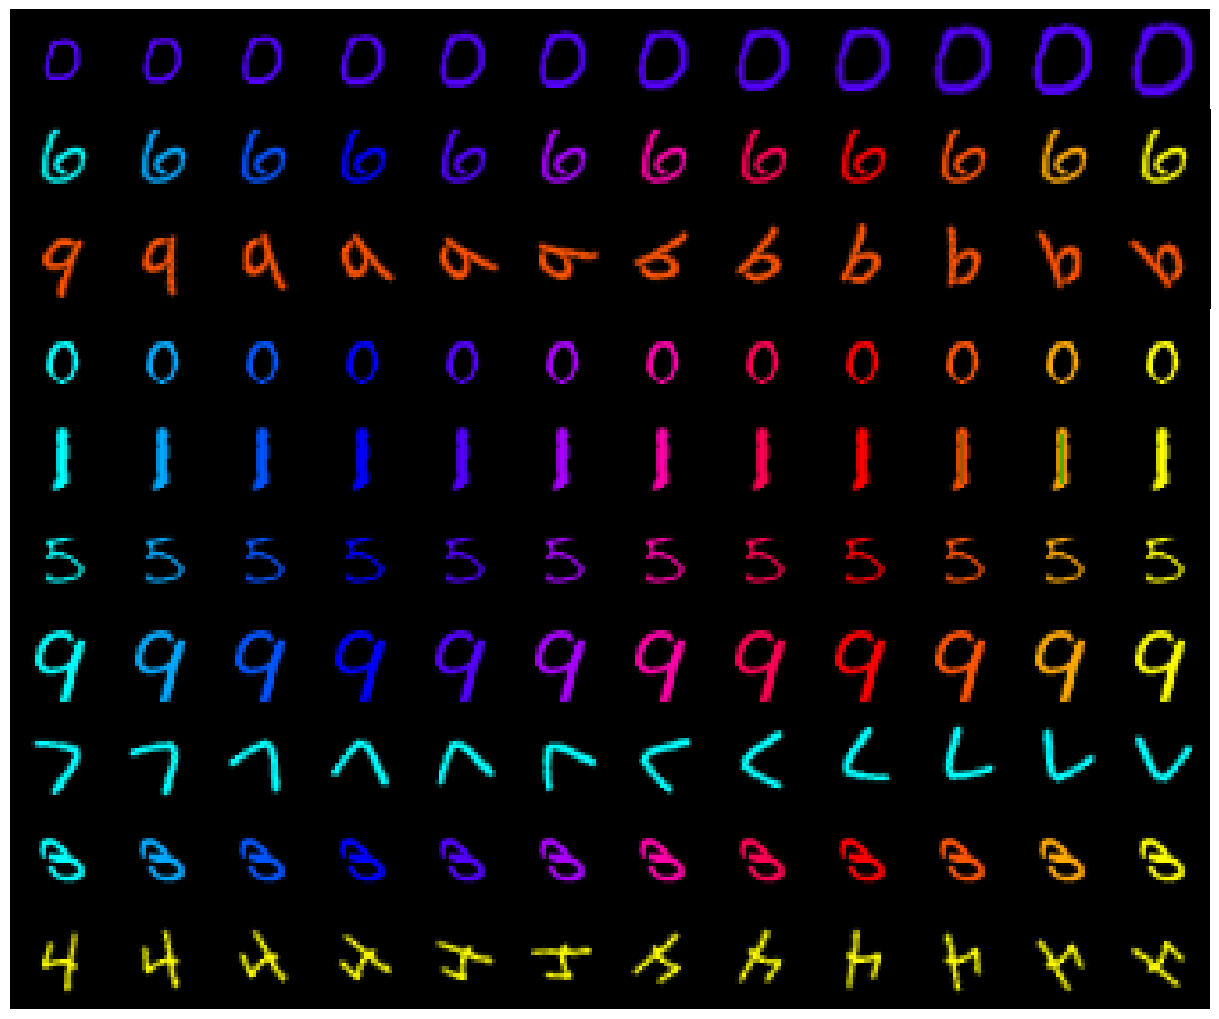

In [68]:
lim = test_data.shape[1]

fig, axes = plt.subplots(10, lim, figsize=(lim, 10))
for i in range(10):
    for k in range(lim):
        axes[i][k].imshow(np.moveaxis(test_data[10+i, k].cpu().numpy(), 0, 2), cmap='gray')
        axes[i][k].axis('off')
plt.tight_layout(pad=0)

In [101]:
input_data = test_data[3].unsqueeze(0).repeat(10, 1, 1, 1, 1)

output = model({'data': input_data, 'seq_mask': torch.ones(10, 12).cuda(), "pix_mask": torch.ones_like(input_data)}, epoch=100000)
recon = output.recon_x.detach()

4


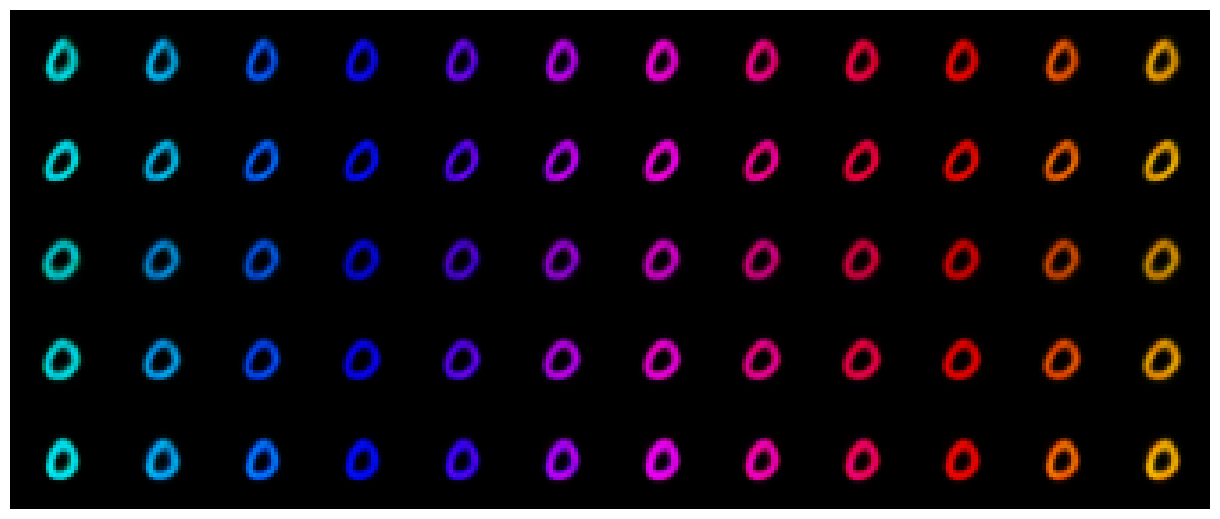

In [103]:
lim = model.n_obs
im_size = 28

idx = torch.randperm(len(recon))

# Train recon
fig, axes = plt.subplots(5, lim, figsize=(lim, 5))
for i in range(5):
    for k in range(lim):
        axes[i][k].imshow(np.moveaxis(recon[i, k].cpu().numpy(), 0, 2), cmap='gray')
        axes[i][k].axis('off')
        
plt.tight_layout(pad=0)
#plt.savefig('plots/possible_evolutions_from_4.png', bbox_inches='tight')

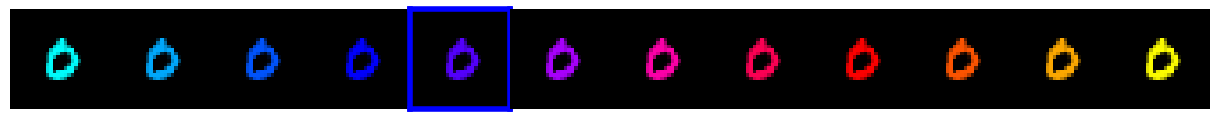

In [124]:
lim = model.n_obs
im_size = 28

idx = torch.randperm(len(recon))

# Train recon
fig, axes = plt.subplots(1, lim, figsize=(lim, 1))
for k in range(lim):
        axes[k].imshow(np.moveaxis(input_data[i, k].cpu().numpy(), 0, 2), cmap='gray')
        if k == 4:
        axes[k].tick_params(
                axis='x',
                which='both',
                bottom=False, 
                top=False,
                labelbottom=False, 
                labeltop=False)
        axes[k].tick_params(
                axis='y',
                which='both',
                left=False, 
                right=False,
                labelleft=False, 
                labelright=False)
                
        else:
                
                axes[k].axis('off')

plt.tight_layout(pad=0)
for axis in ['top', 'bottom', 'right', 'left']:
        axes[4].spines[axis].set_color('blue')
        axes[4].spines[axis].set_linewidth(4)
#plt.savefig('plots/possible_evolutions_from_0_true_sequence.png', bbox_inches='tight')

In [1]:
import torch
from pythae.models import AutoModel
from pythae.trainers import BaseTrainerConfig

device = "cuda" if torch.cuda.is_available() else "cpu"

%load_ext autoreload
%autoreload 2

model = AutoModel.load_from_folder('/home/clement/Documents/rvae/benchmark_VAE/examples/notebooks/from_jz_lvae/models/colormnist/LVAE_IAF_training_2022-12-21_21-51-03/final_model').eval().to(device)
training_config = BaseTrainerConfig.from_json_file('/home/clement/Documents/rvae/benchmark_VAE/examples/notebooks/from_jz_lvae/models/colormnist/LVAE_IAF_training_2022-12-21_21-51-03/final_model/training_config.json')

In [ ]:
nll = [-26078.78575597226, -26078.055985087896, -26077.52499597885, -26077.004953415923, -26077.937710268558]
np.mean(nll)



In [ ]:
from pythae.trainers.training_callbacks import WandbCallback

wandb_cb = WandbCallback()
wandb_cb.setup(
    training_config,
    model_config=model.model_config,
    project_name="jz_longitudinal_vaes_metrics",
    entity_name="clementchadebec",
)

wandb_cb._wandb.config.update({"args": vars(args)})

wandb_cb._wandb.log(metrics)

wandb_cb.on_train_end(training_config)

In [46]:
import pandas as pd 
import numpy as np
import torch

num_missing = {
    "sprites": torch.tensor([
        torch.tensor(58884096.)/ 42,
        torch.tensor(1.1255808000e+08)/ 42,
        torch.tensor(1.5532032000e+08)/ 42,
        torch.tensor(1.8412339200e+08)/ 42,
        torch.tensor(1.5485478400e+08)/ 42,
        torch.tensor(1.8596704000e+08)/ 42,
        torch.tensor(2.0968152000e+08)/ 42,
        torch.tensor(2.3597012800e+08)/ 42,
    ]),
    "starmen": torch.tensor([
        torch.tensor(1376256.) / 2,
        torch.tensor(1671168.) / 2,
        torch.tensor(2605056.) / 2,
        torch.tensor(2867200.) / 2,
        torch.tensor(2129559.) / 2,
        torch.tensor(2848065.) / 2,
        torch.tensor(3171204.) / 2,
        torch.tensor(3603824.) / 2,
    ]),
    "colormnist": torch.tensor([
        torch.tensor(61114368.),
        torch.tensor(1.0770278400e+08),
        torch.tensor(1.6919347200e+08),
        torch.tensor(1.9899801600e+08),
        torch.tensor(1.7017657600e+08),
        torch.tensor(1.9592563200e+08),
        torch.tensor(2.2997504000e+08),
        torch.tensor(2.5323707200e+08),
    ])
}

In [47]:
runs_df = pd.read_csv('lvae_missing.csv')
runs_df
runs_df['args.input_dim']
np.prod(np.array(runs_df['args.input_dim'][0][1:-1].split(',')).astype(np.float))
metrics_lvae = {
    "sprites": {
        "mean_mse": [],
        "std_mse": [],
        "mean_mse_missing": [],
        "std_mse_missing": [],
        "mean_mse_missing_with_best_on_seen": [],
        "std_mse_missing_with_best_on_seen": []
    },
     "starmen": {
        "mean_mse": [],
        "std_mse": [],
        "mean_mse_missing": [],
        "std_mse_missing": [],
        "mean_mse_missing_with_best_on_seen": [],
        "std_mse_missing_with_best_on_seen": []
    },
     "colormnist": {
        "mean_mse": [],
        "std_mse": [],
        "mean_mse_missing": [],
        "std_mse_missing": [],
        "mean_mse_missing_with_best_on_seen": [],
        "std_mse_missing_with_best_on_seen": []
    },
}

metrics_lvamp = {
    "sprites": {
        "mean_mse": [],
        "std_mse": [],
        "mean_mse_missing": [],
        "std_mse_missing": [],
        "mean_mse_missing_with_best_on_seen": [],
        "std_mse_missing_with_best_on_seen": []
    },
     "starmen": {
        "mean_mse": [],
        "std_mse": [],
        "mean_mse_missing": [],
        "std_mse_missing": [],
        "mean_mse_missing_with_best_on_seen": [],
        "std_mse_missing_with_best_on_seen": []
    },
     "colormnist": {
        "mean_mse": [],
        "std_mse": [],
        "mean_mse_missing": [],
        "std_mse_missing": [],
        "mean_mse_missing_with_best_on_seen": [],
        "std_mse_missing_with_best_on_seen": []
    },
}

metrics_lvae_iaf = {
    "sprites": {
        "mean_mse": [],
        "std_mse": [],
        "mean_mse_missing": [],
        "std_mse_missing": [],
        "mean_mse_missing_with_best_on_seen": [],
        "std_mse_missing_with_best_on_seen": []
    },
     "starmen": {
        "mean_mse": [],
        "std_mse": [],
        "mean_mse_missing": [],
        "std_mse_missing": [],
        "mean_mse_missing_with_best_on_seen": [],
        "std_mse_missing_with_best_on_seen": []
    },
     "colormnist": {
        "mean_mse": [],
        "std_mse": [],
        "mean_mse_missing": [],
        "std_mse_missing": [],
        "mean_mse_missing_with_best_on_seen": [],
        "std_mse_missing_with_best_on_seen": []
    },
}

for dataset in metrics_lvae.keys():
    if dataset  == "starmen":
        input_dim = 1*64*64
    elif dataset == "sprites":
        input_dim = 3*64*64
    elif dataset == "colormnist":
        input_dim = 3*28*28
    metrics_lvae[dataset]["mean_mse"] = list(runs_df[runs_df['args.prior']=='standard'][runs_df['args.posterior']=='gaussian'][runs_df['args.dataset'] == dataset]["test/mean_recon"] / input_dim)
    metrics_lvae[dataset]["std_mse"] = list(runs_df[runs_df['args.prior']=='standard'][runs_df['args.posterior']=='gaussian'][runs_df['args.dataset'] == dataset]["test/std_recon"] / input_dim)
    metrics_lvamp[dataset]["mean_mse"] = list(runs_df[runs_df['args.prior']=='vamp'][runs_df['args.posterior']=='gaussian'][runs_df['args.dataset'] == dataset]["test/mean_recon"] / input_dim)
    metrics_lvamp[dataset]["std_mse"] = list(runs_df[runs_df['args.prior']=='vamp'][runs_df['args.posterior']=='gaussian'][runs_df['args.dataset'] == dataset]["test/std_recon"] / input_dim)
    metrics_lvae_iaf[dataset]["mean_mse"] = list(runs_df[runs_df['args.prior']=='standard'][runs_df['args.posterior']=='iaf'][runs_df['args.dataset'] == dataset]["test/mean_recon"] / input_dim)
    metrics_lvae_iaf[dataset]["std_mse"] = list(runs_df[runs_df['args.prior']=='standard'][runs_df['args.posterior']=='iaf'][runs_df['args.dataset'] == dataset]["test/std_recon"] / input_dim)

    metrics_lvae[dataset]["mean_mse_missing"] = list(runs_df[runs_df['args.prior']=='standard'][runs_df['args.posterior']=='gaussian'][runs_df['args.dataset'] == dataset]["test/mean_recon_missing"] / num_missing[dataset])
    metrics_lvae[dataset]["std_mse_missing"] = list(runs_df[runs_df['args.prior']=='standard'][runs_df['args.posterior']=='gaussian'][runs_df['args.dataset'] == dataset]["test/std_recon_missing"] / num_missing[dataset])
    metrics_lvamp[dataset]["mean_mse_missing"] = list(runs_df[runs_df['args.prior']=='vamp'][runs_df['args.posterior']=='gaussian'][runs_df['args.dataset'] == dataset]["test/mean_recon_missing"] / num_missing[dataset])
    metrics_lvamp[dataset]["std_mse_missing"] = list(runs_df[runs_df['args.prior']=='vamp'][runs_df['args.posterior']=='gaussian'][runs_df['args.dataset'] == dataset]["test/std_recon_missing"] / num_missing[dataset])
    metrics_lvae_iaf[dataset]["mean_mse_missing"] = list(runs_df[runs_df['args.prior']=='standard'][runs_df['args.posterior']=='iaf'][runs_df['args.dataset'] == dataset]["test/mean_recon_missing"] / num_missing[dataset])
    metrics_lvae_iaf[dataset]["std_mse_missing"] = list(runs_df[runs_df['args.prior']=='standard'][runs_df['args.posterior']=='iaf'][runs_df['args.dataset'] == dataset]["test/std_recon_missing"] / num_missing[dataset])

    metrics_lvae[dataset]["mean_mse_missing_with_best_on_seen"] = list(runs_df[runs_df['args.prior']=='standard'][runs_df['args.posterior']=='gaussian'][runs_df['args.dataset'] == dataset]["test/mean_recon_missing_with_best_on_seen"] / num_missing[dataset])
    metrics_lvae[dataset]["std_mse_missing_with_best_on_seen"] = list(runs_df[runs_df['args.prior']=='standard'][runs_df['args.posterior']=='gaussian'][runs_df['args.dataset'] == dataset]["test/std_recon_missing_with_best_on_seen"] / num_missing[dataset])
    metrics_lvamp[dataset]["mean_mse_missing_with_best_on_seen"] = list(runs_df[runs_df['args.prior']=='vamp'][runs_df['args.posterior']=='gaussian'][runs_df['args.dataset'] == dataset]["test/mean_recon_missing_with_best_on_seen"] / num_missing[dataset])
    metrics_lvamp[dataset]["std_mse_missing_with_best_on_seen"] = list(runs_df[runs_df['args.prior']=='vamp'][runs_df['args.posterior']=='gaussian'][runs_df['args.dataset'] == dataset]["test/std_recon_missing_with_best_on_seen"] / num_missing[dataset])
    metrics_lvae_iaf[dataset]["mean_mse_missing_with_best_on_seen"] = list(runs_df[runs_df['args.prior']=='standard'][runs_df['args.posterior']=='iaf'][runs_df['args.dataset'] == dataset]["test/mean_recon_missing_with_best_on_seen"] / num_missing[dataset])
    metrics_lvae_iaf[dataset]["std_mse_missing_with_best_on_seen"] = list(runs_df[runs_df['args.prior']=='standard'][runs_df['args.posterior']=='iaf'][runs_df['args.dataset'] == dataset]["test/std_recon_missing_with_best_on_seen"] / num_missing[dataset])



/tmp/ipykernel_27440/3217309069.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.prod(np.array(runs_df['args.input_dim'][0][1:-1].split(',')).astype(np.float))
/tmp/ipykernel_27440/3217309069.py:93: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metrics_lvae[dataset]["mean_mse"] = list(runs_df[runs_df['args.prior']=='standard'][runs_df['args.posterior']=='gaussian'][runs_df['args.dataset'] == dataset]["test/mean_recon"] / input_dim)
/tmp/ipykernel_27440/3217309069.py:94: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metrics_lvae[dataset]["std_mse"] = list(runs_df[runs_df['args.prior']=='standar

In [40]:
runs_df

Name     State Notes             User  Tags  \
0         wobbly-cosmos-17  finished     -  clementchadebec   NaN   
1       jolly-butterfly-80  finished     -  clementchadebec   NaN   
2            zany-dream-32  finished     -  clementchadebec   NaN   
3            soft-shadow-9  finished     -  clementchadebec   NaN   
4            eager-haze-85  finished     -  clementchadebec   NaN   
..                     ...       ...   ...              ...   ...   
92         pious-sponge-88  finished     -  clementchadebec   NaN   
93  blooming-wildflower-24  finished     -  clementchadebec   NaN   
94         valiant-lion-68  finished     -  clementchadebec   NaN   
95          fluent-moon-63  finished     -  clementchadebec   NaN   
96           vital-dust-91  finished     -  clementchadebec   NaN   

                     Created  Runtime  Sweep  args.batch_size  args.beta  ...  \
0   2023-01-05T18:16:47.000Z    65030    NaN               64          1  ...   
1   2023-01-09T09:10:23.000Z    33278    NaN              128          1  ...   
2   2023-01-06T12:09:03.000Z        3    NaN               64          1  ...   
3   2023-01-05T18:15:00.000Z    64845    NaN               64          1  ...   
4   2023-01-09T09:12:33.000Z    33274    NaN              128          1  ...   
..                       ...      ...    ...              ...        ...  ...   
92  2023-01-09T18:59:06.000Z        3    NaN              128          1  ...   
93  2023-01-05T18:18:29.000Z    65015    NaN               64          1  ...   
94  2023-01-07T08:36:32.000Z        3    NaN               64          1  ...   
95  2023-01-07T08:35:29.000Z        3    NaN              128          1  ...   
96  2023-01-09T19:00:13.000Z        3    NaN              128          1  ...   

    training_config.output_dir  training_config.seed training_config.shuffle  \
0             dummy_output_dir                     8                   False   
1             dummy_output_dir                     8                   False   
2             dummy_output_dir                     8                   False   
3             dummy_output_dir                     8                   False   
4             dummy_output_dir                     8                   False   
..                         ...                   ...                     ...   
92            dummy_output_dir                     8                   False   
93            dummy_output_dir                     8                   False   
94            dummy_output_dir                     8                   False   
95            dummy_output_dir                     8                   False   
96            dummy_output_dir                     8                   False   

   training_config.steps_predict  test/mean_recon  test/mean_recon_missing  \
0                             50        31.401178              5958.928125   
1                             50        39.627321             12940.443233   
2                             50        25.266319              3152.201855   
3                             50        30.869490              5874.282520   
4                             50        39.676366             12936.138800   
..                           ...              ...                      ...   
92                            50        58.886312             80048.504648   
93                            50       174.974344             78726.858594   
94                            50       165.574966             76757.344275   
95                            50        57.128248             51991.175705   
96                            50        58.886634             80048.980814   

    test/mean_recon_missing_with_best_on_seen  test/std_recon  \
0                                 4813.079150        1.707120   
1                                 9799.033039        0.183938   
2                                 2078.518747        0.929665   
3                                 4505.242310        1.402845 

In [3]:
metrics_lvae['starmen']

{'mean_mse': [0.007536496641114355,
  0.00797591069713235,
  0.008930416405200956,
  0.011074465792626142,
  0.008845238666981458,
  0.009365721978247166,
  0.01588316047564149,
  0.028542114607989784],
 'std_mse': [0.000342491375598844,
  0.0005032199261127785,
  0.00034767673876054677,
  0.0005101610778034053,
  0.0006856180207005249,
  0.0004759925038942879,
  0.0009553754793787802,
  0.000879486660154938],
 'mean_mse_missing': [0.004268306644220471,
  0.004346001039068301,
  0.004816553936534451,
  0.005857139320312371,
  0.0046988078347419086,
  0.004602879033536987,
  0.00770873372892468,
  0.014306326021314219],
 'std_mse_missing': [0.0004024849021105222,
  0.0003534861831450317,
  0.0002998058577984879,
  0.00018522029014010448,
  0.0004083031396003214,
  0.00034524295653441656,
  0.0002329231102563334,
  0.0002865969712675803],
 'mean_mse_missing_with_best_on_seen': [0.0032735496836976477,
  0.0032805266179739764,
  0.003839891660524595,
  0.004604510428295724,
  0.00315835468

In [4]:
runs_df = pd.read_csv('gpvae_missing.csv')
runs_df
runs_df['args.input_dim']
np.prod(np.array(runs_df['args.input_dim'][0][1:-1].split(',')).astype(np.float))

metrics_gpvae_rbf = {
    "sprites": {
        "mean_mse": [],
        "std_mse": [],
        "mean_mse_missing": [],
        "std_mse_missing": []
    },
     "starmen": {
        "mean_mse": [],
        "std_mse": [],
        "mean_mse_missing": [],
        "std_mse_missing": []
    },
     "colormnist": {
        "mean_mse": [],
        "std_mse": [],
        "mean_mse_missing": [],
        "std_mse_missing": []
    },
}

metrics_gpvae_mattern = {
    "sprites": {
        "mean_mse": [],
        "std_mse": [],
        "mean_mse_missing": [],
        "std_mse_missing": []
    },
     "starmen": {
        "mean_mse": [],
        "std_mse": [],
        "mean_mse_missing": [],
        "std_mse_missing": []
    },
     "colormnist": {
        "mean_mse": [],
        "std_mse": [],
        "mean_mse_missing": [],
        "std_mse_missing": []
    },
}

metrics_gpvae_cauchy = {
    "sprites": {
        "mean_mse": [],
        "std_mse": [],
        "mean_mse_missing": [],
        "std_mse_missing": []
    },
     "starmen": {
        "mean_mse": [],
        "std_mse": [],
        "mean_mse_missing": [],
        "std_mse_missing": []
    },
     "colormnist": {
        "mean_mse": [],
        "std_mse": [],
        "mean_mse_missing": [],
        "std_mse_missing": []
    },
}

metrics_gpvae_diffusion = {
    "sprites": {
        "mean_mse": [],
        "std_mse": [],
        "mean_mse_missing": [],
        "std_mse_missing": []
    },
     "starmen": {
        "mean_mse": [],
        "std_mse": [],
        "mean_mse_missing": [],
        "std_mse_missing": []
    },
     "colormnist": {
        "mean_mse": [],
        "std_mse": [],
        "mean_mse_missing": [],
        "std_mse_missing": []
    },
}



for dataset in metrics_gpvae_mattern.keys():
    if dataset  == "starmen":
        input_dim = 1*64*64
    elif dataset == "sprites":
        input_dim = 3*64*64
    elif dataset == "colormnist":
        input_dim = 3*28*28
    metrics_gpvae_rbf[dataset]["mean_mse"] = list(runs_df[runs_df['args.kernel']=='rbf'][runs_df['args.dataset'] == dataset]["test/mean_recon"] / input_dim)
    metrics_gpvae_rbf[dataset]["std_mse"] = list(runs_df[runs_df['args.kernel']=='rbf'][runs_df['args.dataset'] == dataset]["test/std_recon"] / input_dim)
    metrics_gpvae_mattern[dataset]["mean_mse"] = list(runs_df[runs_df['args.kernel']=='matern'][runs_df['args.dataset'] == dataset]["test/mean_recon"] / input_dim)
    metrics_gpvae_mattern[dataset]["std_mse"] = list(runs_df[runs_df['args.kernel']=='matern'][runs_df['args.dataset'] == dataset]["test/std_recon"] / input_dim)
    metrics_gpvae_cauchy[dataset]["mean_mse"] = list(runs_df[runs_df['args.kernel']=='cauchy'][runs_df['args.dataset'] == dataset]["test/mean_recon"] / input_dim)
    metrics_gpvae_cauchy[dataset]["std_mse"] = list(runs_df[runs_df['args.kernel']=='cauchy'][runs_df['args.dataset'] == dataset]["test/std_recon"] / input_dim)
    metrics_gpvae_diffusion[dataset]["mean_mse"] = list(runs_df[runs_df['args.kernel']=='diffusion'][runs_df['args.dataset'] == dataset]["test/mean_recon"] / input_dim)
    metrics_gpvae_diffusion[dataset]["std_mse"] = list(runs_df[runs_df['args.kernel']=='diffusion'][runs_df['args.dataset'] == dataset]["test/std_recon"] / input_dim)


    metrics_gpvae_rbf[dataset]["mean_mse_missing"] = list(runs_df[runs_df['args.kernel']=='rbf'][runs_df['args.dataset'] == dataset]["test/mean_recon_missing"] / num_missing[dataset])
    metrics_gpvae_rbf[dataset]["std_mse_missing"] = list(runs_df[runs_df['args.kernel']=='rbf'][runs_df['args.dataset'] == dataset]["test/std_recon_missing"] / num_missing[dataset])
    metrics_gpvae_mattern[dataset]["mean_mse_missing"] = list(runs_df[runs_df['args.kernel']=='matern'][runs_df['args.dataset'] == dataset]["test/mean_recon_missing"] / num_missing[dataset])
    metrics_gpvae_mattern[dataset]["std_mse_missing"] = list(runs_df[runs_df['args.kernel']=='matern'][runs_df['args.dataset'] == dataset]["test/std_recon_missing"] / num_missing[dataset])
    metrics_gpvae_cauchy[dataset]["mean_mse_missing"] = list(runs_df[runs_df['args.kernel']=='cauchy'][runs_df['args.dataset'] == dataset]["test/mean_recon_missing"] / num_missing[dataset])
    metrics_gpvae_cauchy[dataset]["std_mse_missing"] = list(runs_df[runs_df['args.kernel']=='cauchy'][runs_df['args.dataset'] == dataset]["test/std_recon_missing"] / num_missing[dataset])
    metrics_gpvae_diffusion[dataset]["mean_mse_missing"] = list(runs_df[runs_df['args.kernel']=='diffusion'][runs_df['args.dataset'] == dataset]["test/mean_recon_missing"] / num_missing[dataset])
    metrics_gpvae_diffusion[dataset]["std_mse_missing"] = list(runs_df[runs_df['args.kernel']=='diffusion'][runs_df['args.dataset'] == dataset]["test/std_recon_missing"] / num_missing[dataset])

/tmp/ipykernel_27440/3630857206.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.prod(np.array(runs_df['args.input_dim'][0][1:-1].split(',')).astype(np.float))
/tmp/ipykernel_27440/3630857206.py:99: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metrics_gpvae_rbf[dataset]["mean_mse"] = list(runs_df[runs_df['args.kernel']=='rbf'][runs_df['args.dataset'] == dataset]["test/mean_recon"] / input_dim)
/tmp/ipykernel_27440/3630857206.py:100: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metrics_gpvae_rbf[dataset]["std_mse"] = list(runs_df[runs_df['args.kernel']=='rbf'][runs_df['args.dataset'] == datas

In [5]:
runs_df[runs_df['args.kernel']=='diffusion'][runs_df['args.dataset'] == "starmen"]["test/mean_recon"]

/tmp/ipykernel_27440/1276951990.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  runs_df[runs_df['args.kernel']=='diffusion'][runs_df['args.dataset'] == "starmen"]["test/mean_recon"]


7      160.068602
19     207.545944
42     294.578967
63     319.341705
75     189.228603
91     202.554366
103    210.725403
116    196.449150
Name: test/mean_recon, dtype: float64

In [6]:
runs_df = pd.read_csv('tvae_missing.csv')

metrics_bubbles = {
     "sprites": {
        "mean_mse": [],
        "std_mse": [],
        "mean_mse_missing": [],
        "std_mse_missing": []
    },
     "starmen": {
        "mean_mse": [],
        "std_mse": [],
        "mean_mse_missing": [],
        "std_mse_missing": []
    },
     "colormnist": {
        "mean_mse": [],
        "std_mse": [],
        "mean_mse_missing": [],
        "std_mse_missing": []
    },
}

metrics_tvae_0 = {
     "sprites": {
        "mean_mse": [],
        "std_mse": [],
        "mean_mse_missing": [],
        "std_mse_missing": []
    },
     "starmen": {
        "mean_mse": [],
        "std_mse": [],
        "mean_mse_missing": [],
        "std_mse_missing": []
    },
     "colormnist": {
        "mean_mse": [],
        "std_mse": [],
        "mean_mse_missing": [],
        "std_mse_missing": []
    },
}

metrics_tvae_short = {
     "sprites": {
        "mean_mse": [],
        "std_mse": [],
        "mean_mse_missing": [],
        "std_mse_missing": []
    },
     "starmen": {
        "mean_mse": [],
        "std_mse": [],
        "mean_mse_missing": [],
        "std_mse_missing": []
    },
     "colormnist": {
        "mean_mse": [],
        "std_mse": [],
        "mean_mse_missing": [],
        "std_mse_missing": []
    },
}

metrics_tvae_part = {
     "sprites": {
        "mean_mse": [],
        "std_mse": [],
        "mean_mse_missing": [],
        "std_mse_missing": []
    },
     "starmen": {
        "mean_mse": [],
        "std_mse": [],
        "mean_mse_missing": [],
        "std_mse_missing": []
    },
     "colormnist": {
        "mean_mse": [],
        "std_mse": [],
        "mean_mse_missing": [],
        "std_mse_missing": []
    },
}

metrics_tvae_half = {
    "sprites": {
        "mean_mse": [],
        "std_mse": [],
        "mean_mse_missing": [],
        "std_mse_missing": []
    },
     "starmen": {
        "mean_mse": [],
        "std_mse": [],
        "mean_mse_missing": [],
        "std_mse_missing": []
    },
     "colormnist": {
        "mean_mse": [],
        "std_mse": [],
        "mean_mse_missing": [],
        "std_mse_missing": []
    },
}

for dataset in metrics_bubbles.keys():
    if dataset  == "starmen":
        input_dim = 1*64*64
        dataset_key = dataset
    elif dataset == "sprites":
        input_dim = 3*64*64
        dataset_key = dataset
    elif dataset == "colormnist":
        dataset_key = "zcolormnist"
        input_dim = 3*28*28
        
    metrics_bubbles[dataset]["mean_mse"] = list(runs_df[runs_df.Tags == 'bubbles, ' + dataset_key]["mean recon loss: "] / input_dim)
    metrics_bubbles[dataset]["std_mse"] = list(runs_df[runs_df.Tags == 'bubbles, ' + dataset_key]["std recon loss: "] / input_dim)
    metrics_tvae_0[dataset]["mean_mse"] = list(runs_df[runs_df.Tags == '0, ' + dataset_key]["mean recon loss: "] / input_dim)
    metrics_tvae_0[dataset]["std_mse"] = list(runs_df[runs_df.Tags == '0, ' + dataset_key]["std recon loss: "] / input_dim)
    metrics_tvae_short[dataset]["mean_mse"] = list(runs_df[runs_df.Tags == 'short, ' + dataset_key]["mean recon loss: "] / input_dim)
    metrics_tvae_short[dataset]["std_mse"] = list(runs_df[runs_df.Tags == 'short, ' + dataset_key]["std recon loss: "] / input_dim)
    metrics_tvae_part[dataset]["mean_mse"] = list(runs_df[runs_df.Tags == 'part, ' + dataset_key]["mean recon loss: "] / input_dim)
    metrics_tvae_part[dataset]["std_mse"] = list(runs_df[runs_df.Tags == 'part, ' + dataset_key]["std recon loss: "] / input_dim)
    metrics_tvae_half[dataset]["mean_mse"] = list(runs_df[runs_df.Tags == 'half, ' + dataset_key]["mean recon loss: "] / input_dim)
    metrics_tvae_half[dataset]["std_mse"] = list(runs_df[runs_df.Tags == 'half, ' + dataset_key]["std recon loss: "] / input_dim)


    metrics_bubbles[dataset]["mean_mse_missing"] = list(runs_df[runs_df.Tags == 'bubbles, ' + dataset_key]["mean missing recon loss: "] / num_missing[dataset])
    metrics_bubbles[dataset]["std_mse_missing"] = list(runs_df[runs_df.Tags == 'bubbles, ' + dataset_key]["std missing recon loss: "] / num_missing[dataset])
    metrics_tvae_0[dataset]["mean_mse_missing"] = list(runs_df[runs_df.Tags == '0, ' + dataset_key]["mean missing recon loss: "] / num_missing[dataset])
    metrics_tvae_0[dataset]["std_mse_missing"] = list(runs_df[runs_df.Tags == '0, ' + dataset_key]["std missing recon loss: "] / num_missing[dataset])
    metrics_tvae_short[dataset]["mean_mse_missing"] = list(runs_df[runs_df.Tags == 'short, ' + dataset_key]["mean missing recon loss: "] / num_missing[dataset])
    metrics_tvae_short[dataset]["std_mse_missing"] = list(runs_df[runs_df.Tags == 'short, ' + dataset_key]["std missing recon loss: "] / num_missing[dataset])
    metrics_tvae_part[dataset]["mean_mse_missing"] = list(runs_df[runs_df.Tags == 'part, ' + dataset_key]["mean missing recon loss: "] / num_missing[dataset])
    metrics_tvae_part[dataset]["std_mse_missing"] = list(runs_df[runs_df.Tags == 'part, ' + dataset_key]["std missing recon loss: "] / num_missing[dataset])
    metrics_tvae_half[dataset]["mean_mse_missing"] = list(runs_df[runs_df.Tags == 'half, ' + dataset_key]["mean missing recon loss: "] / num_missing[dataset])
    metrics_tvae_half[dataset]["std_mse_missing"] = list(runs_df[runs_df.Tags == 'half, ' + dataset_key]["std missing recon loss: "] / num_missing[dataset])

In [7]:
metrics_tvae_half['colormnist']

{'mean_mse': [0.013225111182855099,
  0.016257697059994653,
  0.01988306240159638,
  0.0209770020984468,
  0.01986149314309464,
  0.020245486214047387,
  0.021257958120229296,
  0.025033153482034904],
 'std_mse': [9.49417175336318e-06,
  1.6687231652520704e-05,
  1.4447863821948342e-05,
  1.7822292172091794e-05,
  1.4787537777436778e-05,
  1.8567325215461478e-05,
  1.8558891477715264e-05,
  1.3806965754907314e-06],
 'mean_mse_missing': [0.00017327694612860982,
  0.00021235637567505462,
  0.0002577272479115131,
  0.00027148404464260104,
  0.00025558040568940084,
  0.0002583244978299794,
  0.0002698247762381138,
  0.00031605516072871347],
 'std_mse_missing': [2.896012384079891e-07,
  3.2010923118686557e-07,
  1.439678632315771e-07,
  3.890731585162513e-07,
  1.6495380608024075e-07,
  2.958540758220037e-07,
  3.002146415829648e-07,
  1.6946552616645996e-08]}

In [8]:
import seaborn as sns

palette  = sns.color_palette("tab20")
palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

In [9]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 25,
          'figure.figsize': (15, 5),
         'axes.labelsize': 25,
         'axes.titlesize':25,
         'xtick.labelsize':25,
         'ytick.labelsize':25}
pylab.rcParams.update(params)

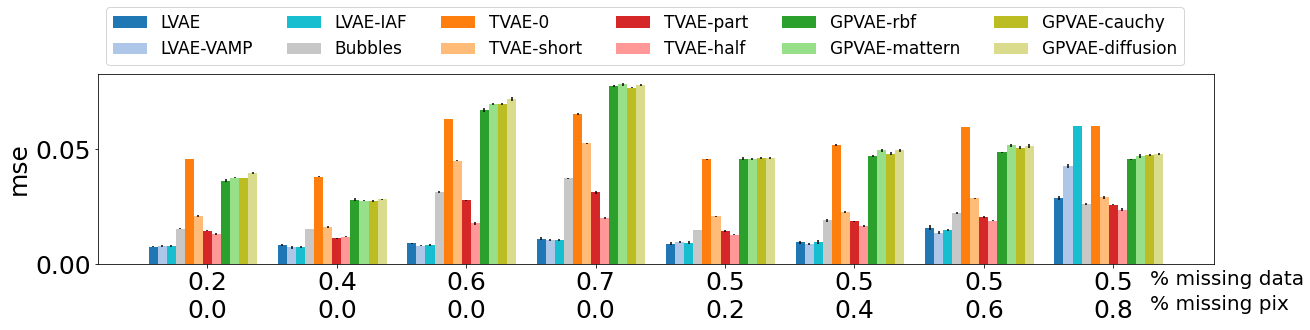

In [54]:
import matplotlib.pyplot as plt

#plt.bar(np.arange(7), metrics_lvae_iaf['sprites']['mean_mse'], yerr=metrics_lvae_iaf['sprites']['std_mse'], width=0.2)
#plt.bar(np.arange(7)-0.2, metrics_lvamp['sprites']['mean_mse'], yerr=metrics_lvae_iaf['sprites']['std_mse'], width=0.2)

bar_width = 0.07

import seaborn as sns

palette  = sns.color_palette("tab20")

x_ticks = [
    '0.2\n0.0',
    '0.4\n0.0',
    '0.6\n0.0',
    '0.7\n0.0',
    '0.5\n0.2',
    '0.5\n0.4',
    '0.5\n0.6',
    '0.5\n0.8'
    ]


dataset = 'starmen'

plt.figure(figsize=(20, 3.5))

plt.bar(np.arange(8), metrics_lvae[dataset]['mean_mse'], yerr=metrics_lvae[dataset]['std_mse'], width=bar_width, align='center', label='LVAE', color=palette[0])
plt.bar(np.arange(8)+bar_width, metrics_lvamp[dataset]['mean_mse'], yerr=metrics_lvamp[dataset]['std_mse'], width=bar_width, align='center', label='LVAE-VAMP', color=palette[1])
plt.bar(np.arange(8)+bar_width*2, metrics_lvae_iaf[dataset]['mean_mse'], yerr=metrics_lvae_iaf[dataset]['std_mse'], width=bar_width, align='center', label='LVAE-IAF', color=palette[-2])

plt.bar(np.arange(8)+bar_width*3, metrics_bubbles[dataset]['mean_mse'], yerr=metrics_bubbles[dataset]['std_mse'], width=bar_width, align='center', label='Bubbles', color=palette[-5])

plt.bar(np.arange(8)+bar_width*4, metrics_tvae_0[dataset]['mean_mse'], yerr=metrics_tvae_0[dataset]['std_mse'], width=bar_width, align='center', label='TVAE-0', color=palette[2])
plt.bar(np.arange(8)+bar_width*5, metrics_tvae_short[dataset]['mean_mse'], yerr=metrics_tvae_short[dataset]['std_mse'], width=bar_width, align='center', label='TVAE-short', color=palette[3])
plt.bar(np.arange(8)+bar_width*6, metrics_tvae_part[dataset]['mean_mse'], yerr=metrics_tvae_part[dataset]['std_mse'], width=bar_width, align='center', label='TVAE-part', color=palette[6])
plt.bar(np.arange(8)+bar_width*7, metrics_tvae_half[dataset]['mean_mse'], yerr=metrics_tvae_half[dataset]['std_mse'], width=bar_width, align='center', label='TVAE-half', color=palette[7])

plt.bar(np.arange(8)+bar_width*8, metrics_gpvae_rbf[dataset]['mean_mse'], yerr=metrics_gpvae_rbf[dataset]['std_mse'], width=bar_width, align='center', label='GPVAE-rbf', color=palette[4])
plt.bar(np.arange(8)+bar_width*9, metrics_gpvae_mattern[dataset]['mean_mse'], yerr=metrics_gpvae_mattern[dataset]['std_mse'], width=bar_width, align='center', label='GPVAE-mattern', color=palette[5])
plt.bar(np.arange(8)+bar_width*10, metrics_gpvae_cauchy[dataset]['mean_mse'], yerr=metrics_gpvae_cauchy[dataset]['std_mse'], width=bar_width, align='center', label='GPVAE-cauchy', color=palette[-4])
plt.bar(np.arange(8)+bar_width*11, metrics_gpvae_diffusion[dataset]['mean_mse'], yerr=metrics_gpvae_diffusion[dataset]['std_mse'], width=bar_width, align='center', label='GPVAE-diffusion', color=palette[-3])


 #plt.bar(np.arange(8)+bar_width*11, metrics_lvae[dataset]['mean_mse'], yerr=metrics_lvae[dataset]['std_mse'], width=bar_width, align='center', label='LVAE', color=palette[2])
 #plt.bar(np.arange(7)+bar_width*12, metrics_lvamp[dataset]['mean_mse'], yerr=metrics_lvamp[dataset]['std_mse'], width=bar_width, align='center', label='LVAMP', color=palette[3])
 #plt.bar(np.arange(7)+bar_width*13, metrics_lvae_iaf[dataset]['mean_mse'], yerr=metrics_lvae_iaf[dataset]['std_mse'], width=bar_width, align='center', label='LVAE-IAF', color=palette[6])
 #plt.bar(np.arange(7)+bar_width*14, metrics_lvae_iaf[dataset]['mean_mse'], yerr=metrics_lvae_iaf[dataset]['std_mse'], width=bar_width, align='center', label='LVAE-IAF', color=palette[7])
 #plt.bar(np.arange(7)+bar_width*15, metrics_lvae_iaf[dataset]['mean_mse'], yerr=metrics_lvae_iaf[dataset]['std_mse'], width=bar_width, align='center', label='LVAE-IAF', color=palette[11])


plt.xticks(np.arange(8)+bar_width*6, x_ticks)

plt.legend(ncol=6, fontsize=17, bbox_to_anchor=(0, 1.0, 1, 0.))
plt.text(7.7, -0.009, '% missing data', fontsize=20)
plt.text(7.7, -0.02, '% missing pix', fontsize=20)
plt.ylabel('mse')
#plt.show()
plt.savefig(f'plots/mse_missing_{dataset}.pdf', bbox_inches="tight")

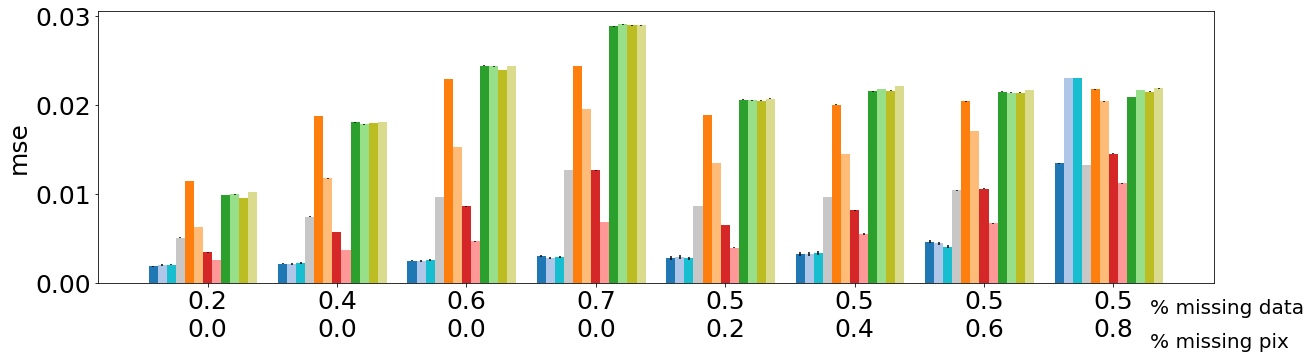

In [55]:
import matplotlib.pyplot as plt

#plt.bar(np.arange(7), metrics_lvae_iaf['sprites']['mean_mse'], yerr=metrics_lvae_iaf['sprites']['std_mse'], width=0.2)
#plt.bar(np.arange(7)-0.2, metrics_lvamp['sprites']['mean_mse'], yerr=metrics_lvae_iaf['sprites']['std_mse'], width=0.2)

bar_width = 0.07

import seaborn as sns

palette  = sns.color_palette("tab20")

x_ticks = [
    '0.2\n0.0',
    '0.4\n0.0',
    '0.6\n0.0',
    '0.7\n0.0',
    '0.5\n0.2',
    '0.5\n0.4',
    '0.5\n0.6',
    '0.5\n0.8'
    ]


dataset = 'sprites'

plt.figure(figsize=(20, 5))

plt.bar(np.arange(8), metrics_lvae[dataset]['mean_mse'], yerr=metrics_lvae[dataset]['std_mse'], width=bar_width, align='center', label='LVAE', color=palette[0])
plt.bar(np.arange(8)+bar_width, metrics_lvamp[dataset]['mean_mse'], yerr=metrics_lvamp[dataset]['std_mse'], width=bar_width, align='center', label='LVAE-VAMP', color=palette[1])
plt.bar(np.arange(8)+bar_width*2, metrics_lvae_iaf[dataset]['mean_mse'], yerr=metrics_lvae_iaf[dataset]['std_mse'], width=bar_width, align='center', label='LVAE-IAF', color=palette[-2])

plt.bar(np.arange(8)+bar_width*3, metrics_bubbles[dataset]['mean_mse'], yerr=metrics_bubbles[dataset]['std_mse'], width=bar_width, align='center', label='Bubbles', color=palette[-5])

plt.bar(np.arange(8)+bar_width*4, metrics_tvae_0[dataset]['mean_mse'], yerr=metrics_tvae_0[dataset]['std_mse'], width=bar_width, align='center', label='TVAE-0', color=palette[2])
plt.bar(np.arange(8)+bar_width*5, metrics_tvae_short[dataset]['mean_mse'], yerr=metrics_tvae_short[dataset]['std_mse'], width=bar_width, align='center', label='TVAE-short', color=palette[3])
plt.bar(np.arange(8)+bar_width*6, metrics_tvae_part[dataset]['mean_mse'], yerr=metrics_tvae_part[dataset]['std_mse'], width=bar_width, align='center', label='TVAE-part', color=palette[6])
plt.bar(np.arange(8)+bar_width*7, metrics_tvae_half[dataset]['mean_mse'], yerr=metrics_tvae_half[dataset]['std_mse'], width=bar_width, align='center', label='TVAE-half', color=palette[7])

plt.bar(np.arange(8)+bar_width*8, metrics_gpvae_rbf[dataset]['mean_mse'], yerr=metrics_gpvae_rbf[dataset]['std_mse'], width=bar_width, align='center', label='GPVAE-rbf', color=palette[4])
plt.bar(np.arange(8)+bar_width*9, metrics_gpvae_mattern[dataset]['mean_mse'], yerr=metrics_gpvae_mattern[dataset]['std_mse'], width=bar_width, align='center', label='GPVAE-mattern', color=palette[5])
plt.bar(np.arange(8)+bar_width*10, metrics_gpvae_cauchy[dataset]['mean_mse'], yerr=metrics_gpvae_cauchy[dataset]['std_mse'], width=bar_width, align='center', label='GPVAE-cauchy', color=palette[-4])
plt.bar(np.arange(8)+bar_width*11, metrics_gpvae_diffusion[dataset]['mean_mse'], yerr=metrics_gpvae_diffusion[dataset]['std_mse'], width=bar_width, align='center', label='GPVAE-cauchy', color=palette[-3])


 #plt.bar(np.arange(8)+bar_width*11, metrics_lvae[dataset]['mean_mse'], yerr=metrics_lvae[dataset]['std_mse'], width=bar_width, align='center', label='LVAE', color=palette[2])
 #plt.bar(np.arange(7)+bar_width*12, metrics_lvamp[dataset]['mean_mse'], yerr=metrics_lvamp[dataset]['std_mse'], width=bar_width, align='center', label='LVAMP', color=palette[3])
 #plt.bar(np.arange(7)+bar_width*13, metrics_lvae_iaf[dataset]['mean_mse'], yerr=metrics_lvae_iaf[dataset]['std_mse'], width=bar_width, align='center', label='LVAE-IAF', color=palette[6])
 #plt.bar(np.arange(7)+bar_width*14, metrics_lvae_iaf[dataset]['mean_mse'], yerr=metrics_lvae_iaf[dataset]['std_mse'], width=bar_width, align='center', label='LVAE-IAF', color=palette[7])
 #plt.bar(np.arange(7)+bar_width*15, metrics_lvae_iaf[dataset]['mean_mse'], yerr=metrics_lvae_iaf[dataset]['std_mse'], width=bar_width, align='center', label='LVAE-IAF', color=palette[11])


plt.xticks(np.arange(8)+bar_width*6, x_ticks)

#plt.legend(ncol=6, fontsize=17, bbox_to_anchor=(0, 1.0, 1, 0.))
plt.text(7.7, -0.0035, '% missing data', fontsize=20)
plt.text(7.7, -0.0073, '% missing pix', fontsize=20)
plt.ylabel('mse')
#plt.show()
plt.savefig(f'plots/mse_missing_{dataset}.pdf', bbox_inches="tight")

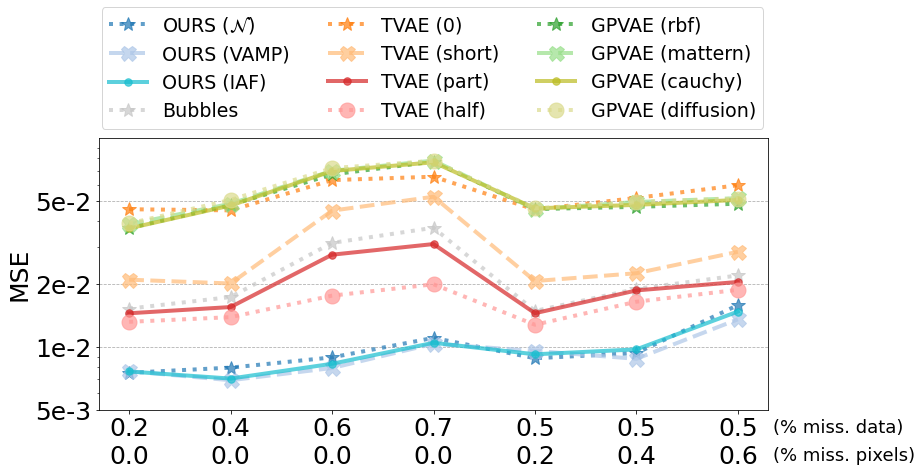

In [10]:
import seaborn as sns
import matplotlib.pyplot  as plt

palette  = sns.color_palette("tab20")

x_ticks = [
    '0.2\n0.0',
    '0.4\n0.0',
    '0.6\n0.0',
    '0.7\n0.0',
    '0.5\n0.2',
    '0.5\n0.4',
    '0.5\n0.6',
    #'0.5\n0.8'
    ]

y = np.array([0.001, 0.002, 0.005, 0.01, 0.02, 0.05])
y_ticks = ["1e-3", "2e-3", "5e-3", "1e-2", "2e-2", "5e-2"]

ls = [
    'dotted',
    '--',
    '-',
    ':']

marker = [
    "*",
    "X",
    ".",
    "o"
]

dataset = 'starmen'

plt.figure(figsize=(12, 5))

x = np.arange(7)

s = 70

plt.semilogy(x, metrics_lvae[dataset]['mean_mse'][:7], label=r'OURS ($\mathcal{N}$)', color=palette[0], marker=marker[0], linewidth=4, linestyle=ls[0], markersize=15, alpha=0.7)
plt.semilogy(x, metrics_lvamp[dataset]['mean_mse'][:7],  label='OURS (VAMP)', color=palette[1], marker=marker[1], linewidth=4, linestyle=ls[1], markersize=15, alpha=0.7)
plt.semilogy(x, metrics_lvae_iaf[dataset]['mean_mse'][:7], label='OURS (IAF)', color=palette[-2], marker=marker[2], linewidth=4, linestyle=ls[2], markersize=15, alpha=0.7)
plt.semilogy(x, metrics_bubbles[dataset]['mean_mse'][:7], label='Bubbles', color=palette[-5], marker=marker[0], linewidth=4, linestyle=ls[0], markersize=15, alpha=0.7)
plt.semilogy(x, metrics_tvae_0[dataset]['mean_mse'][:7], label='TVAE (0)', color=palette[2], marker=marker[0], linewidth=4, linestyle=ls[0], markersize=15, alpha=0.7)
plt.semilogy(x, metrics_tvae_short[dataset]['mean_mse'][:7], label='TVAE (short)', color=palette[3], marker=marker[1], linewidth=4, linestyle=ls[1], markersize=15, alpha=0.7)
plt.semilogy(x, metrics_tvae_part[dataset]['mean_mse'][:7], label='TVAE (part)', color=palette[6], marker=marker[2], linewidth=4, linestyle=ls[2], markersize=15, alpha=0.7)
plt.semilogy(x, metrics_tvae_half[dataset]['mean_mse'][:7], label='TVAE (half)', color=palette[7], marker=marker[3], linewidth=4, linestyle=ls[3], markersize=15, alpha=0.7)
plt.semilogy(x, metrics_gpvae_rbf[dataset]['mean_mse'][:7], label='GPVAE (rbf)', color=palette[4], marker=marker[0], linewidth=4, linestyle=ls[0], markersize=15, alpha=0.7)
plt.semilogy(x, metrics_gpvae_mattern[dataset]['mean_mse'][:7], label='GPVAE (mattern)', color=palette[5], marker=marker[1], linewidth=4, linestyle=ls[1], markersize=15, alpha=0.7)
plt.semilogy(x, metrics_gpvae_cauchy[dataset]['mean_mse'][:7], label='GPVAE (cauchy)', color=palette[-4], marker=marker[2], linewidth=4, linestyle=ls[2], markersize=15, alpha=0.7)
plt.semilogy(x, metrics_gpvae_diffusion[dataset]['mean_mse'][:7], label='GPVAE (diffusion)', color=palette[-3], marker=marker[3], linewidth=4, linestyle=ls[3], markersize=15, alpha=0.7)

plt.xticks(x, x_ticks)
plt.yticks(y, y_ticks)

plt.ylim(0.005, 0.1)

#plt.legend(ncol=6, fontsize=17, bbox_to_anchor=(0, 1.0, 1, 0.))
plt.text(6.35, -np.log(0.99612), '(% miss. data)', fontsize=18)
plt.text(6.35, -np.log(0.99715), '(% miss. pixels)', fontsize=18)
plt.grid(axis="y", linestyle='--')
plt.ylabel('MSE')
plt.legend(ncol=3, fontsize=19, bbox_to_anchor=(-0.01, 1, 0.9, 0.))
#plt.show()
#plt.savefig(f'plots/mse_missing_{dataset}_plots.pdf', bbox_inches="tight")

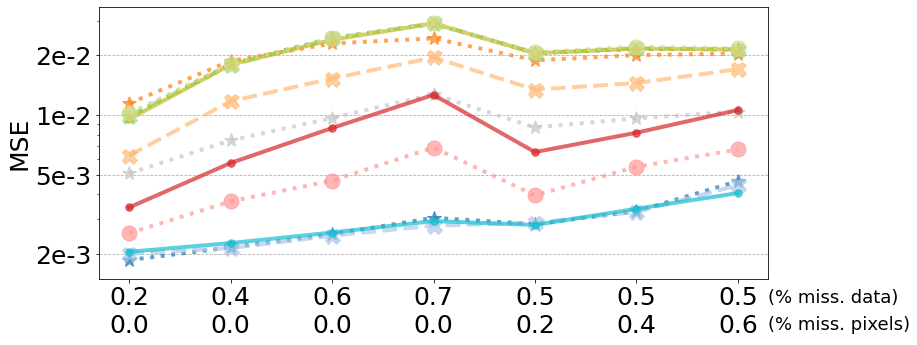

In [27]:
import seaborn as sns
import matplotlib.pyplot  as plt

palette  = sns.color_palette("tab20")

x_ticks = [
    '0.2\n0.0',
    '0.4\n0.0',
    '0.6\n0.0',
    '0.7\n0.0',
    '0.5\n0.2',
    '0.5\n0.4',
    '0.5\n0.6',
    #'0.5\n0.8'
    ]

y = np.array([0.001, 0.002, 0.005, 0.01, 0.02, 0.05])
y_ticks = ["1e-3", "2e-3", "5e-3", "1e-2", "2e-2", "5e-2"]

ls = [
    'dotted',
    '--',
    '-',
    ':']

marker = [
    "*",
    "X",
    ".",
    "o"
]

dataset = 'sprites'

plt.figure(figsize=(12, 5))

x = np.arange(7)

s = 70

plt.semilogy(x, metrics_lvae[dataset]['mean_mse'][:7], label='LVAE', color=palette[0], marker=marker[0], linewidth=4, linestyle=ls[0], markersize=15, alpha=0.7)
plt.semilogy(x, metrics_lvamp[dataset]['mean_mse'][:7],  label='LVAE-VAMP', color=palette[1], marker=marker[1], linewidth=4, linestyle=ls[1], markersize=15, alpha=0.7)
plt.semilogy(x, metrics_lvae_iaf[dataset]['mean_mse'][:7], label='LVAE-IAF', color=palette[-2], marker=marker[2], linewidth=4, linestyle=ls[2], markersize=15, alpha=0.7)
plt.semilogy(x, metrics_bubbles[dataset]['mean_mse'][:7], label='Bubbles', color=palette[-5], marker=marker[0], linewidth=4, linestyle=ls[0], markersize=15, alpha=0.7)
plt.semilogy(x, metrics_tvae_0[dataset]['mean_mse'][:7], label='TVAE-0', color=palette[2], marker=marker[0], linewidth=4, linestyle=ls[0], markersize=15, alpha=0.7)
plt.semilogy(x, metrics_tvae_short[dataset]['mean_mse'][:7], label='TVAE-short', color=palette[3], marker=marker[1], linewidth=4, linestyle=ls[1], markersize=15, alpha=0.7)
plt.semilogy(x, metrics_tvae_part[dataset]['mean_mse'][:7], label='TVAE-part', color=palette[6], marker=marker[2], linewidth=4, linestyle=ls[2], markersize=15, alpha=0.7)
plt.semilogy(x, metrics_tvae_half[dataset]['mean_mse'][:7], label='TVAE-half', color=palette[7], marker=marker[3], linewidth=4, linestyle=ls[3], markersize=15, alpha=0.7)
plt.semilogy(x, metrics_gpvae_rbf[dataset]['mean_mse'][:7], label='GPVAE-rbf', color=palette[4], marker=marker[0], linewidth=4, linestyle=ls[0], markersize=15, alpha=0.7)
plt.semilogy(x, metrics_gpvae_mattern[dataset]['mean_mse'][:7], label='GPVAE-mattern', color=palette[5], marker=marker[1], linewidth=4, linestyle=ls[1], markersize=15, alpha=0.7)
plt.semilogy(x, metrics_gpvae_cauchy[dataset]['mean_mse'][:7], label='GPVAE-cauchy', color=palette[-4], marker=marker[2], linewidth=4, linestyle=ls[2], markersize=15, alpha=0.7)
plt.semilogy(x, metrics_gpvae_diffusion[dataset]['mean_mse'][:7], label='GPVAE-cauchy', color=palette[-3], marker=marker[3], linewidth=4, linestyle=ls[3], markersize=15, alpha=0.7)

plt.xticks(x, x_ticks)
plt.yticks(y, y_ticks)

plt.ylim(0.0015, 0.035)

#plt.legend(ncol=6, fontsize=17, bbox_to_anchor=(0, 1.0, 1, 0.))
plt.text(6.3, -np.log(0.99886), '(% miss. data)', fontsize=18)
plt.text(6.3, -np.log(0.99917), '(% miss. pixels)', fontsize=18)
plt.grid(axis="y", linestyle='--')
plt.ylabel('MSE')
#plt.legend(ncol=3, fontsize=20, bbox_to_anchor=(0, 1, 1, 0.))
#plt.show()
#plt.savefig(f'plots/mse_missing_{dataset}_plots.pdf', bbox_inches="tight")

Text(6.2, 11300.49, '(MADE layers in block)')

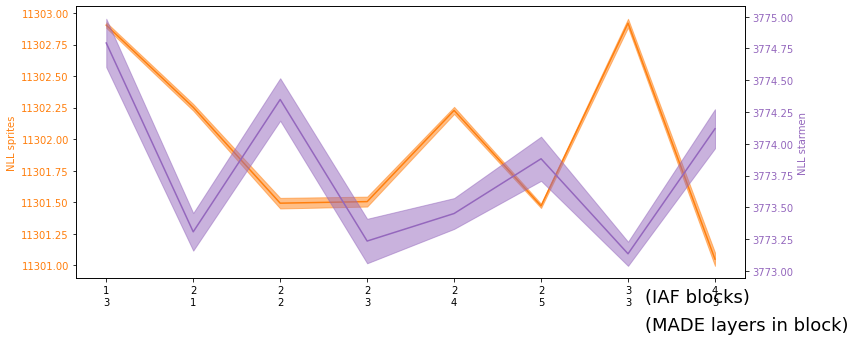

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot  as plt
import matplotlib
from matplotlib.ticker import FormatStrFormatter


palette  = sns.color_palette("tab20")


mean_nll_sprites = np.array(
    [
        90423.229,
        90418.021,
        90411.945,
        90412.044,
        90417.824,
        90411.772,
        90423.355,
        90408.396,
    ]
) / 8

std_nll_sprites = np.array(
    [
        0.176,
        0.2128,
        0.3359,
        0.3149,
        0.225,
        0.1338,
        0.2761,
        0.4242,
    ]
) / 8

mean_nll_starmen = [
    37747.934 / 10,
    37733.068 / 10,
    37743.486 / 10,
    37732.343 / 10,
    37734.51 / 10,
    37738.82 / 10,
    37731.34 / 10,
    37741.182 / 10,
]

std_nll_starmen = [
    1.905 / 10,
    1.479/ 10,
    1.67/ 10,
    1.75 / 10,
    1.213 / 10,
    1.738 / 10,
    0.9511 / 10,
    1.538 / 10,
] 

x_ticks = [
    '1\n3',
    '2\n1',
    '2\n2',
    '2\n3',
    '2\n4',
    '2\n5',
    '3\n3',
    '4\n3',
    ]
    

#y = np.array([0.001, 0.002, 0.005, 0.01, 0.02, 0.05])
#y_ticks = ["1e-3", "2e-3", "5e-3", "1e-2", "2e-2", "5e-2"]

ls = [
    'dotted',
    '--',
    '-',
    ':']

marker = [
    "*",
    "X",
    ".",
    "o"
]

dataset = 'sprites'


fig, ax1 = plt.subplots(figsize=(12, 5))

x = np.arange(8)

s = 70


ax1.plot(x, mean_nll_sprites, c=palette[2])
ax1.fill_between(x, np.array(mean_nll_sprites) - np.array(std_nll_sprites), np.array(mean_nll_sprites) + np.array(std_nll_sprites), alpha=0.5, color=palette[2])
ax1.tick_params(axis='y', labelcolor=palette[2])
ax1.set_ylabel("NLL sprites", color=palette[2])

ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


ax2 = ax1.twinx()

ax2.plot(x, mean_nll_starmen, c=palette[8])
ax2.tick_params(axis='y', labelcolor=palette[8])
ax2.set_ylabel("NLL starmen", color=palette[8])
ax2.fill_between(x, np.array(mean_nll_starmen) - np.array(std_nll_starmen), np.array(mean_nll_starmen) + np.array(std_nll_starmen), alpha=0.5, color=palette[8])

ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.xticks(np.arange(8), x_ticks)
#plt.yticks(y, y_ticks)

#plt.ylim(0.0015, 0.035)

#plt.legend(ncol=6, fontsize=17, bbox_to_anchor=(0, 1.0, 1, 0.))
ax1.text(6.2, 11300.71, '(IAF blocks)', fontsize=18)
ax1.text(6.2, 11300.49, '(MADE layers in block)', fontsize=18)
#ax1.grid(axis="y", linestyle='--')
#ax2.grid(axis="y", linestyle='--')
#plt.legend(ncol=3, fontsize=20, bbox_to_anchor=(0, 1, 1, 0.))
#plt.show()
#plt.savefig(f'plots/nll_flow_ablation_plots.pdf', bbox_inches="tight")

In [6]:
np.round(std_nll_starmen, 2)

array([0.19, 0.15, 0.17, 0.18, 0.12, 0.17, 0.1 , 0.15])

([<matplotlib.axis.XTick at 0x7fed0648c430>,
 [Text(0, 0, '2'),
  Text(1, 0, '5'),
  Text(2, 0, '10'),
  Text(3, 0, '20'),
  Text(4, 0, '50'),
  Text(5, 0, '100')])

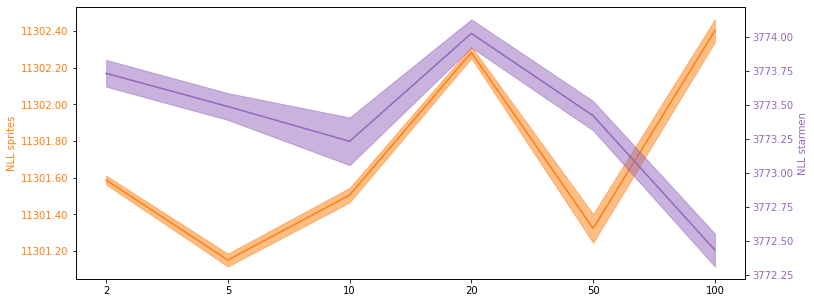

In [7]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot  as plt
import matplotlib
from matplotlib.ticker import FormatStrFormatter


palette  = sns.color_palette("tab20")


mean_nll_sprites = np.array(
    [
        90412.7,
        90409.209,
        90412.044,
        90418.271,
        90410.588,
        90419.22,
    ]
) / 8

std_nll_sprites = np.array(
    [
        0.1931,
        0.2793,
        0.3149,
        0.2512,
        0.6247,
        0.4938
    ]
) / 8

mean_nll_starmen = [
    37737.34 / 10,
    37734.9 / 10,
    37732.343 / 10,
    37740.272 / 10,
    37734.225 / 10,
    37724.354 / 10
]

std_nll_starmen = [
    0.9819 / 10,
    0.9842/ 10,
    1.75 / 10,
    1.032 / 10,
    1.082 / 10,
    1.207 / 10
] 

x_ticks = [
    '2',
    '5',
    '10',
    '20',
    '50',
    '100',
    ]
    

#y = np.array([0.001, 0.002, 0.005, 0.01, 0.02, 0.05])
#y_ticks = ["1e-3", "2e-3", "5e-3", "1e-2", "2e-2", "5e-2"]

ls = [
    'dotted',
    '--',
    '-',
    ':']

marker = [
    "*",
    "X",
    ".",
    "o"
]

dataset = 'sprites'

fig, ax1 = plt.subplots(figsize=(12, 5))

x = np.arange(6)

s = 70


ax1.plot(x, mean_nll_sprites, c=palette[2])
ax1.fill_between(x, np.array(mean_nll_sprites) - np.array(std_nll_sprites), np.array(mean_nll_sprites) + np.array(std_nll_sprites), alpha=0.5, color=palette[2])
ax1.tick_params(axis='y', labelcolor=palette[2])
ax1.set_ylabel("NLL sprites", color=palette[2])

ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


ax2 = ax1.twinx()

ax2.plot(x, mean_nll_starmen, c=palette[8])
ax2.tick_params(axis='y', labelcolor=palette[8])
ax2.set_ylabel("NLL starmen", color=palette[8])
ax2.fill_between(x, np.array(mean_nll_starmen) - np.array(std_nll_starmen), np.array(mean_nll_starmen) + np.array(std_nll_starmen), alpha=0.5, color=palette[8])

ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.xticks(np.arange(6), x_ticks)
#plt.yticks(y, y_ticks)

#plt.ylim(0.0015, 0.035)

#plt.legend(ncol=6, fontsize=17, bbox_to_anchor=(0, 1.0, 1, 0.))
#ax1.text(6.2, 11300.71, '(IAF blocks)', fontsize=18)
#ax1.text(6.2, 11300.49, '(MADE layers in block)', fontsize=18)
#ax1.grid(axis="y", linestyle='--')
#ax2.grid(axis="y", linestyle='--')
#plt.legend(ncol=3, fontsize=20, bbox_to_anchor=(0, 1, 1, 0.))
#plt.show()
#plt.savefig(f'plots/nll_warmup_ablation_plots.pdf', bbox_inches="tight")

In [18]:
mean_nll_sprites = np.array(
    [
        90422.566,
        90410.075,
        90416.541,
        90416.224,
        90410.369
        
        
        
    ]
) / 8

std_nll_sprites = np.array(
    [
        0.2844,
        0.1965,
        0.2191,
        0.2703,
        0.1871,
        
    ]
) / 8

mean_nll_starmen = [
    37735.507 / 10,
    37727.147 / 10,
    37728.919 / 10,
    37726.622 / 10,
    37729.149 / 10
]

std_nll_starmen = [
    0.7154 / 10,
    1.497 / 10,
    1.577 / 10,
    2.159 / 10,
    1.615 / 100
,
] 


In [22]:
np.round(std_nll_starmen, 2)

array([0.07, 0.15, 0.16, 0.22, 0.02])

([<matplotlib.axis.XTick at 0x7fed06191040>,
 [Text(0, 0, '2'),
  Text(1, 0, '8'),
  Text(2, 0, '16'),
  Text(3, 0, '32'),
  Text(4, 0, '64')])

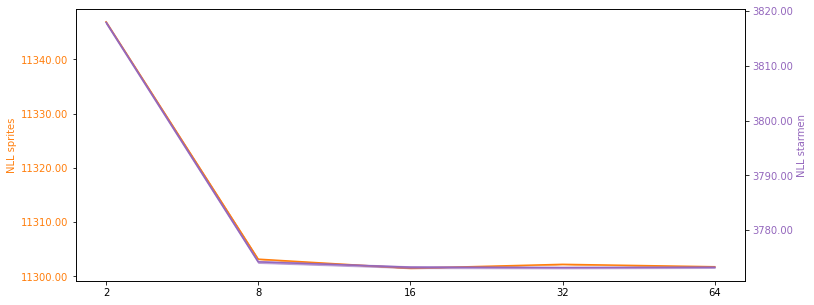

In [12]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot  as plt
import matplotlib
from matplotlib.ticker import FormatStrFormatter


palette  = sns.color_palette("tab20")


mean_nll_sprites = np.array(
    [
        90775.364,
        90425.444,
        90412.044,
        90417.825,
        90414.291,
    ]
) / 8

std_nll_sprites = np.array(
    [
        0.7098,
        0.1767,
        0.3149,
        0.1623,
        0.1309,
        
    ]
) / 8

mean_nll_starmen = [
    38179.152 / 10,
    37741.974 / 10,
    37732.343 / 10,
    37731.598 / 10,
    37732.2 / 10
]

std_nll_starmen = [
    1.994 / 10,
    1.928 / 10,
    1.75 / 10,
    1.576 / 10,
    1.338 / 10
] 

x_ticks = [
    '2',
    '8',
    '16',
    '32',
    '64'
    ]
    

#y = np.array([0.001, 0.002, 0.005, 0.01, 0.02, 0.05])
#y_ticks = ["1e-3", "2e-3", "5e-3", "1e-2", "2e-2", "5e-2"]

ls = [
    'dotted',
    '--',
    '-',
    ':']

marker = [
    "*",
    "X",
    ".",
    "o"
]

dataset = 'sprites'

fig, ax1 = plt.subplots(figsize=(12, 5))

x = np.arange(5)

s = 70


ax1.plot(x, mean_nll_sprites, c=palette[2])
ax1.fill_between(x, np.array(mean_nll_sprites) - np.array(std_nll_sprites), np.array(mean_nll_sprites) + np.array(std_nll_sprites), alpha=0.5, color=palette[2])
ax1.tick_params(axis='y', labelcolor=palette[2])
ax1.set_ylabel("NLL sprites", color=palette[2])

ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


ax2 = ax1.twinx()

ax2.plot(x, mean_nll_starmen, c=palette[8])
ax2.tick_params(axis='y', labelcolor=palette[8])
ax2.set_ylabel("NLL starmen", color=palette[8])
ax2.fill_between(x, np.array(mean_nll_starmen) - np.array(std_nll_starmen), np.array(mean_nll_starmen) + np.array(std_nll_starmen), alpha=0.5, color=palette[8])

ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.xticks(np.arange(5), x_ticks)
#plt.yticks(y, y_ticks)

#plt.ylim(0.0015, 0.035)

#plt.legend(ncol=6, fontsize=17, bbox_to_anchor=(0, 1.0, 1, 0.))
#ax1.text(6.2, 11300.71, '(IAF blocks)', fontsize=18)
#ax1.text(6.2, 11300.49, '(MADE layers in block)', fontsize=18)
#ax1.grid(axis="y", linestyle='--')
#ax2.grid(axis="y", linestyle='--')
#plt.legend(ncol=3, fontsize=20, bbox_to_anchor=(0, 1, 1, 0.))
#plt.show()
#plt.savefig(f'plots/nll_warmup_ablation_plots.pdf', bbox_inches="tight")

In [17]:
np.round(std_nll_starmen, 2)

array([0.2 , 0.19, 0.18, 0.16, 0.13])

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot  as plt
import matplotlib
from matplotlib.ticker import FormatStrFormatter


palette  = sns.color_palette("tab20")


mean_nll_sprites = np.array(
    [
        90775.364,
        90425.444,
        90412.044,
        90417.825,
        90414.291,
    ]
) / 8

std_nll_sprites = np.array(
    [
        0.7098,
        0.1767,
        0.3149,
        0.1623,
        0.1309,
        
    ]
) / 8

mean_nll_starmen = [
    38179.152 / 10,
    37741.974 / 10,
    37732.343 / 10,
    37731.598 / 10,
    37732.2 / 10
]

std_nll_starmen = [
    1.994 / 10,
    1.928 / 10,
    1.75 / 10,
    1.576 / 10,
    1.338 / 10
] 

x_ticks = [
    '2',
    '8',
    '16',
    '32',
    '64'
    ]
    

#y = np.array([0.001, 0.002, 0.005, 0.01, 0.02, 0.05])
#y_ticks = ["1e-3", "2e-3", "5e-3", "1e-2", "2e-2", "5e-2"]

ls = [
    'dotted',
    '--',
    '-',
    ':']

marker = [
    "*",
    "X",
    ".",
    "o"
]

dataset = 'sprites'

fig, ax1 = plt.subplots(figsize=(12, 5))

x = np.arange(5)

s = 70


ax1.plot(x, mean_nll_sprites, c=palette[2])
ax1.fill_between(x, np.array(mean_nll_sprites) - np.array(std_nll_sprites), np.array(mean_nll_sprites) + np.array(std_nll_sprites), alpha=0.5, color=palette[2])
ax1.tick_params(axis='y', labelcolor=palette[2])
ax1.set_ylabel("NLL sprites", color=palette[2])

ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


ax2 = ax1.twinx()

ax2.plot(x, mean_nll_starmen, c=palette[8])
ax2.tick_params(axis='y', labelcolor=palette[8])
ax2.set_ylabel("NLL starmen", color=palette[8])
ax2.fill_between(x, np.array(mean_nll_starmen) - np.array(std_nll_starmen), np.array(mean_nll_starmen) + np.array(std_nll_starmen), alpha=0.5, color=palette[8])

ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.xticks(np.arange(5), x_ticks)
#plt.yticks(y, y_ticks)

#plt.ylim(0.0015, 0.035)

#plt.legend(ncol=6, fontsize=17, bbox_to_anchor=(0, 1.0, 1, 0.))
#ax1.text(6.2, 11300.71, '(IAF blocks)', fontsize=18)
#ax1.text(6.2, 11300.49, '(MADE layers in block)', fontsize=18)
#ax1.grid(axis="y", linestyle='--')
#ax2.grid(axis="y", linestyle='--')
#plt.legend(ncol=3, fontsize=20, bbox_to_anchor=(0, 1, 1, 0.))
#plt.show()
#plt.savefig(f'plots/nll_warmup_ablation_plots.pdf', bbox_inches="tight")

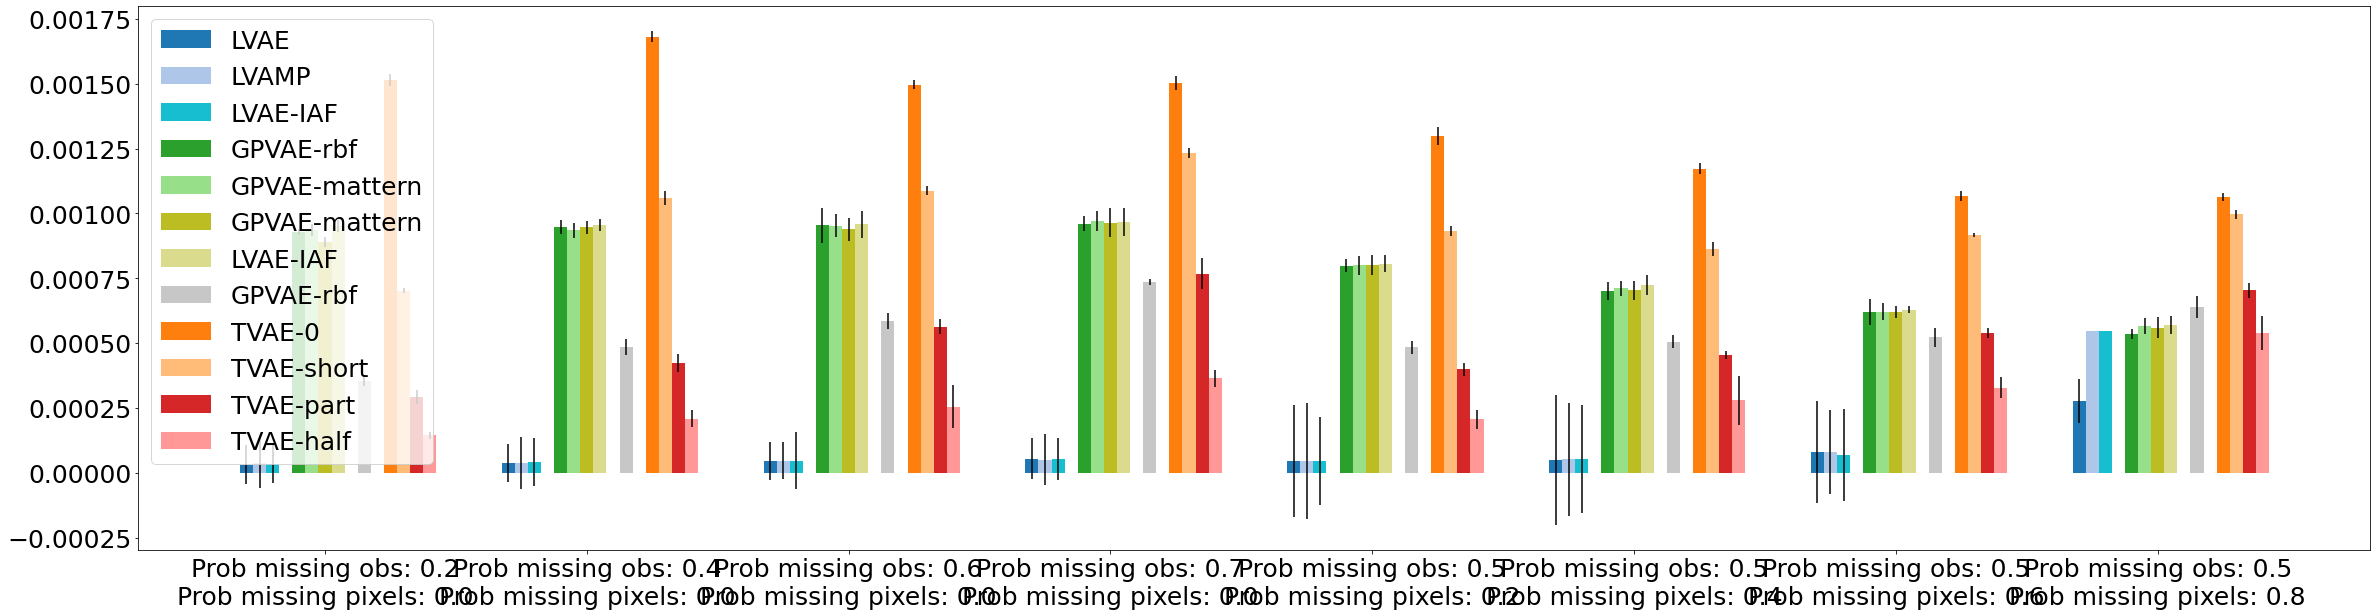

In [10]:
import matplotlib.pyplot as plt

#plt.bar(np.arange(7), metrics_lvae_iaf['sprites']['mean_mse'], yerr=metrics_lvae_iaf['sprites']['std_mse'], width=0.2)
#plt.bar(np.arange(7)-0.2, metrics_lvamp['sprites']['mean_mse'], yerr=metrics_lvae_iaf['sprites']['std_mse'], width=0.2)


import seaborn as sns

palette  = sns.color_palette("tab20")

x_ticks = [
    'Prob missing obs: 0.2\nProb missing pixels: 0.0',
    'Prob missing obs: 0.4\nProb missing pixels: 0.0',
    'Prob missing obs: 0.6\nProb missing pixels: 0.0',
    'Prob missing obs: 0.7\nProb missing pixels: 0.0',
    'Prob missing obs: 0.5\nProb missing pixels: 0.2',
    'Prob missing obs: 0.5\nProb missing pixels: 0.4',
    'Prob missing obs: 0.5\nProb missing pixels: 0.6',
    'Prob missing obs: 0.5\nProb missing pixels: 0.8'
    ]


dataset = 'sprites'

plt.figure(figsize=(40, 10))

plt.bar(np.arange(8), metrics_lvae[dataset]['mean_mse_missing_with_best_on_seen'], yerr=metrics_lvae[dataset]['std_mse'], width=0.05, align='center', label='LVAE', color=palette[0])
plt.bar(np.arange(8)+0.05, metrics_lvamp[dataset]['mean_mse_missing_with_best_on_seen'], yerr=metrics_lvamp[dataset]['std_mse'], width=0.05, align='center', label='LVAMP', color=palette[1])
plt.bar(np.arange(8)+0.05*2, metrics_lvae_iaf[dataset]['mean_mse_missing_with_best_on_seen'], yerr=metrics_lvae_iaf[dataset]['std_mse'], width=0.05, align='center', label='LVAE-IAF', color=palette[-2])


plt.bar(np.arange(8)+0.05*4, metrics_gpvae_rbf[dataset]['mean_mse_missing'], yerr=metrics_gpvae_rbf[dataset]['std_mse'], width=0.05, align='center', label='GPVAE-rbf', color=palette[4])
plt.bar(np.arange(8)+0.05*5, metrics_gpvae_mattern[dataset]['mean_mse_missing'], yerr=metrics_gpvae_mattern[dataset]['std_mse'], width=0.05, align='center', label='GPVAE-mattern', color=palette[5])
plt.bar(np.arange(8)+0.05*6, metrics_gpvae_cauchy[dataset]['mean_mse_missing'], yerr=metrics_gpvae_cauchy[dataset]['std_mse'], width=0.05, align='center', label='GPVAE-mattern', color=palette[-4])
plt.bar(np.arange(8)+0.05*7, metrics_gpvae_diffusion[dataset]['mean_mse_missing'], yerr=metrics_gpvae_diffusion[dataset]['std_mse'], width=0.05, align='center', label='LVAE-IAF', color=palette[-3])

plt.bar(np.arange(8)+0.05*9, metrics_bubbles[dataset]['mean_mse_missing'], yerr=metrics_bubbles[dataset]['std_mse'], width=0.05, align='center', label='GPVAE-rbf', color=palette[-5])

plt.bar(np.arange(8)+0.05*11, metrics_tvae_0[dataset]['mean_mse_missing'], yerr=metrics_tvae_0[dataset]['std_mse'], width=0.05, align='center', label='TVAE-0', color=palette[2])
plt.bar(np.arange(8)+0.05*12, metrics_tvae_short[dataset]['mean_mse_missing'], yerr=metrics_tvae_short[dataset]['std_mse'], width=0.05, align='center', label='TVAE-short', color=palette[3])
plt.bar(np.arange(8)+0.05*13, metrics_tvae_part[dataset]['mean_mse_missing'], yerr=metrics_tvae_part[dataset]['std_mse'], width=0.05, align='center', label='TVAE-part', color=palette[6])
plt.bar(np.arange(8)+0.05*14, metrics_tvae_half[dataset]['mean_mse_missing'], yerr=metrics_tvae_half[dataset]['std_mse'], width=0.05, align='center', label='TVAE-half', color=palette[7])


 #plt.bar(np.arange(8)+0.05*11, metrics_lvae[dataset]['mean_mse'], yerr=metrics_lvae[dataset]['std_mse'], width=0.05, align='center', label='LVAE', color=palette[2])
 #plt.bar(np.arange(7)+0.05*12, metrics_lvamp[dataset]['mean_mse'], yerr=metrics_lvamp[dataset]['std_mse'], width=0.05, align='center', label='LVAMP', color=palette[3])
 #plt.bar(np.arange(7)+0.05*13, metrics_lvae_iaf[dataset]['mean_mse'], yerr=metrics_lvae_iaf[dataset]['std_mse'], width=0.05, align='center', label='LVAE-IAF', color=palette[6])
 #plt.bar(np.arange(7)+0.05*14, metrics_lvae_iaf[dataset]['mean_mse'], yerr=metrics_lvae_iaf[dataset]['std_mse'], width=0.05, align='center', label='LVAE-IAF', color=palette[7])
 #plt.bar(np.arange(7)+0.05*15, metrics_lvae_iaf[dataset]['mean_mse'], yerr=metrics_lvae_iaf[dataset]['std_mse'], width=0.05, align='center', label='LVAE-IAF', color=palette[11])


plt.xticks(np.arange(8)+0.05*6, x_ticks)

plt.legend()
plt.show()


In [14]:
import seaborn as sns

palette  = sns.color_palette("Paired")
palette

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

/tmp/ipykernel_27440/1714326790.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.xticks(np.arange(7)+0.08*3.5, x_ticks, minor=True)


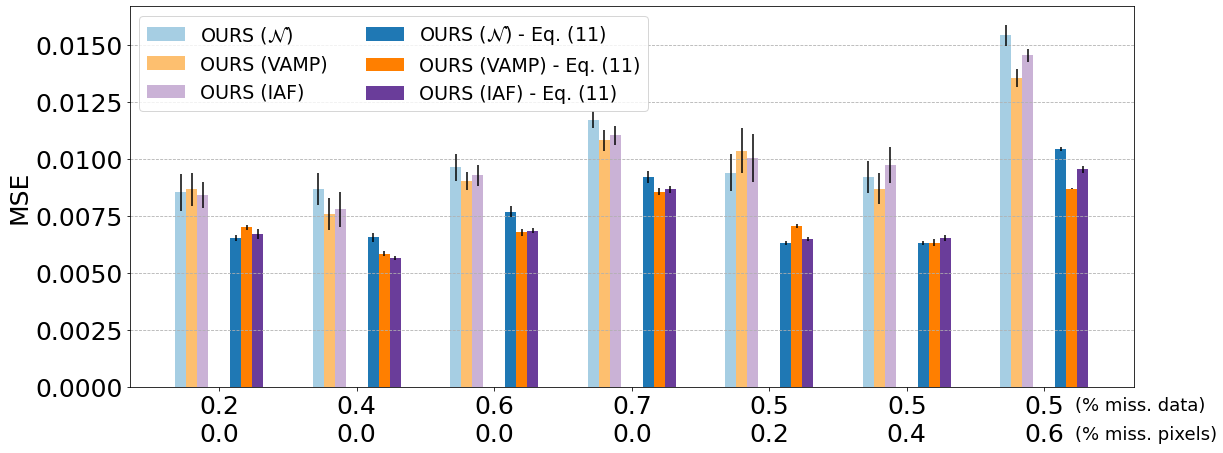

In [113]:
import matplotlib.pyplot as plt
#plt.bar(np.arange(7), metrics_lvae_iaf['sprites']['mean_mse'], yerr=metrics_lvae_iaf['sprites']['std_mse'], width=0.2)
#plt.bar(np.arange(7)-0.2, metrics_lvamp['sprites']['mean_mse'], yerr=metrics_lvae_iaf['sprites']['std_mse'], width=0.2)

import seaborn as sns

palette  = sns.color_palette("Paired")
palette


x_ticks = [
    '0.2\n0.0',
    '0.4\n0.0',
    '0.6\n0.0',
    '0.7\n0.0',
    '0.5\n0.2',
    '0.5\n0.4',
    '0.5\n0.6',
    #'0.5\n0.8'
    ]

y = np.array([0.00001, 0.00002, 0.00005, 0.0001, 0.00015])
y_ticks = ["1e-5", "2e-3", "5e-3", "1e-2", "2e-2", "5e-2"]


dataset = 'starmen'

plt.figure(figsize=(18, 7))

plt.bar(np.arange(7), metrics_lvae[dataset]['mean_mse_missing'][:7], yerr=metrics_lvae[dataset]['std_mse_missing'][:7], width=0.08, align='center', label=r'OURS ($\mathcal{N}$)', color=palette[0])
plt.bar(np.arange(7)+0.08, metrics_lvamp[dataset]['mean_mse_missing'][:7], yerr=metrics_lvamp[dataset]['std_mse_missing'][:7], width=0.08, align='center', label='OURS (VAMP)', color=palette[6])
plt.bar(np.arange(7)+0.08*2, metrics_lvae_iaf[dataset]['mean_mse_missing'][:7], yerr=metrics_lvae_iaf[dataset]['std_mse_missing'][:7], width=0.08, align='center', label='OURS (IAF)', color=palette[8])

plt.bar(np.arange(7)+0.08*5, metrics_lvae[dataset]['mean_mse_missing_with_best_on_seen'][:7], yerr=metrics_lvae[dataset]['std_mse_missing_with_best_on_seen'][:7], width=0.08, align='center', label=r'OURS ($\mathcal{N}$) - Eq. (11)', color=palette[1])
plt.bar(np.arange(7)+0.08*6, metrics_lvamp[dataset]['mean_mse_missing_with_best_on_seen'][:7], yerr=metrics_lvamp[dataset]['std_mse_missing_with_best_on_seen'][:7], width=0.08, align='center', label=r'OURS (VAMP) - Eq. (11)', color=palette[7])
plt.bar(np.arange(7)+0.08*7, metrics_lvae_iaf[dataset]['mean_mse_missing_with_best_on_seen'][:7], yerr=metrics_lvae_iaf[dataset]['std_mse_missing_with_best_on_seen'][:7], width=0.08, align='center', label=r'OURS (IAF) - Eq. (11)', color=palette[9])

 #plt.bar(np.arange(8)+0.05*11, metrics_lvae[dataset]['mean_mse'], yerr=metrics_lvae[dataset]['std_mse'], width=0.05, align='center', label='LVAE', color=palette[2])
 #plt.bar(np.arange(7)+0.05*12, metrics_lvamp[dataset]['mean_mse'], yerr=metrics_lvamp[dataset]['std_mse'], width=0.05, align='center', label='LVAMP', color=palette[3])
 #plt.bar(np.arange(7)+0.05*13, metrics_lvae_iaf[dataset]['mean_mse'], yerr=metrics_lvae_iaf[dataset]['std_mse'], width=0.05, align='center', label='LVAE-IAF', color=palette[6])
 #plt.bar(np.arange(7)+0.05*14, metrics_lvae_iaf[dataset]['mean_mse'], yerr=metrics_lvae_iaf[dataset]['std_mse'], width=0.05, align='center', label='LVAE-IAF', color=palette[7])
 #plt.bar(np.arange(7)+0.05*15, metrics_lvae_iaf[dataset]['mean_mse'], yerr=metrics_lvae_iaf[dataset]['std_mse'], width=0.05, align='center', label='LVAE-IAF', color=palette[11])


plt.xticks(np.arange(7)+0.08*3.5, x_ticks)
plt.xticks(np.arange(7)+0.08*3.5, x_ticks, minor=True)
#plt.yticks(y, y_ticks)

plt.text(6.5, -0.001, '(% miss. data)', fontsize=18)
plt.text(6.5, -0.0023, '(% miss. pixels)', fontsize=18)
plt.grid(axis="y", linestyle='--')
plt.legend(ncol=2, fontsize=19)
plt.ylabel('MSE')
#plt.savefig(f'plots/eq_11_influence_mse_missing_{dataset}_plots.pdf', bbox_inches="tight")
plt.show()


In [41]:
sprites_num_missing = [
    torch.tensor(58884096.),
    torch.tensor(1.1255808000e+08),
    torch.tensor(1.5532032000e+08),
    torch.tensor(1.8412339200e+08),
    torch.tensor(1.5485478400e+08),
    torch.tensor(1.8596704000e+08),
    torch.tensor(2.0968152000e+08),
    torch.tensor(2.3597012800e+08),
]

In [42]:
starmen_num_missing = [
    torch.tensor(1376256.),
    torch.tensor(1081344.),
    torch.tensor(2605056.),
    torch.tensor(2867200.),
    torch.tensor(2129559.),
    torch.tensor(2848065.),
    torch.tensor(3171204.),
    torch.tensor(3603824.),
]

In [43]:
color_num_missing = [
    torch.tensor(61114368.),
    torch.tensor(1.0770278400e+08),
    torch.tensor(1.6919347200e+08),
    torch.tensor(1.9899801600e+08),
    torch.tensor(1.7017657600e+08),
    torch.tensor(1.9592563200e+08),
    torch.tensor(2.2997504000e+08),
    torch.tensor(2.5323707200e+08),
]

In [79]:
3*64*64*8*2664 * (1 - (1-0.5052552223205566) * 0.5052552223205566 - 0.8000316023826599)

25908841.57238368

In [92]:
3*64*64*8*2664 * (1-0.5052552223205566)*0.8000316023826599 + 3*64*64*8*2664*0.5052552223205566

235973014.42761633

In [93]:
3*64*64*8*2664*0.7030780911445618

184123395.421875